In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
all_pitches = pd.read_csv('2024_Complete_TrackMan_Data.csv')
all_pitches = all_pitches[['Date', 'Pitcher', 'PitcherTeam', 'PitcherThrows', 'TaggedPitchType', 'PitchCall', 'PlayResult', 'RelSpeed', 'PlateLocHeight', 'PlateLocSide', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'Level', 'PitchReleaseConfidence', 'PitchLocationConfidence', 'PitchMovementConfidence']]

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\3657786436.py:1: DtypeWarning: Columns (27,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  all_pitches = pd.read_csv('2024_Complete_TrackMan_Data.csv')


In [34]:
# Select D1 pitches with high confidence levels to eliminate misreads
all_pitches = all_pitches[(all_pitches['Level'] == 'D1') & (all_pitches['PitchReleaseConfidence'] == 'High') & (all_pitches['PitchLocationConfidence'] == 'High') & (all_pitches['PitchMovementConfidence'] == 'High')].drop(columns = ['Level', 'PitchReleaseConfidence', 'PitchLocationConfidence', 'PitchMovementConfidence'])
# Take out pitches with unknown pitch types
all_pitches = all_pitches[(all_pitches['TaggedPitchType'] != 'Other') & (all_pitches['TaggedPitchType'] != 'Undefined')].reset_index()
# Get common names for FF and FS
all_pitches['TaggedPitchType'] = all_pitches['TaggedPitchType'].replace({
    'FourSeamFastBall': 'Fastball',
    'TwoSeamFastBall': 'Sinker',
    'OneSeamFastBall': 'Fastball'
})
all_pitches

index        Date         Pitcher PitcherTeam PitcherThrows  \
0              0  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
1              1  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
2              2  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
3              3  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
4              4  2024-02-16  Scavone, Tommy     PEP_WAV         Right   
...          ...         ...             ...         ...           ...   
1436838  1698263  2024-06-24    Combs, Aaron     TEN_VOL         Right   
1436839  1698264  2024-06-24    Combs, Aaron     TEN_VOL         Right   
1436840  1698265  2024-06-24    Combs, Aaron     TEN_VOL         Right   
1436841  1698266  2024-06-24    Combs, Aaron     TEN_VOL         Right   
1436842  1698267  2024-06-24    Combs, Aaron     TEN_VOL         Right   

        TaggedPitchType       PitchCall PlayResult  RelSpeed  PlateLocHeight  \
0              Fastball          InPlay        Out  92.46566         2.30371   
1              Fastball      BallCalled  Undefined  94.01239         2.20297   
2              Fastball      BallCalled  Undefined  93.53813         1.84496   
3              Fastball    StrikeCalled  Undefined  93.45011         2.69952   
4              Fastball      BallCalled  Undefined  93.07141         1.31319   
...                 ...             ...        ...       ...             ...   
1436838        Fastball  StrikeSwinging  Undefined  92.18631         3.18957   
1436839        Fastball    StrikeCalled  Undefined  92.64280         3.09837   
1436840        Fastball  StrikeSwinging  Undefined  93.60782         3.60768   
1436841        Fastball      BallCalled  Undefined  92.70635         4.86704   
1436842          Slider  StrikeSwinging  Undefined  78.95801         1.23877   

         PlateLocSide  RelHeight  RelSide  Extension  InducedVertBreak  \
0            -0.09952    6.13502  1.45834    6.56930          18.21572   
1             1.03802    6.17463  1.25285    6.63680          21.27690   
2            -2.62468    6.14964  1.27202    6.64242          21.71631   
3            -0.96273    6.18241  1.33551    6.46509          21.84749   
4             0.73596    6.19217  1.18000    6.64494          22.33170   
...               ...        ...      ...        ...               ...   
1436838       0.77831    4.79234  1.48251    5.16822          12.64422   
1436839      -0.84427    4.86392  1.38315    5.05159          15.40280   
1436840      -0.76626    5.06982  1.12860    5.29399          17.26068   
1436841      -1.41462    4.83466  1.39461    5.42663          16.00694   
1436842      -0.92484    4.91003  1.38229    4.84387         -12.73579   

         HorzBreak  VertApprAngle  HorzApprAngle  
0         12.71343      -5.595635      -0.544808  
1         10.33087      -5.367363       0.705133  
2          9.66796      -5.726439      -3.375209  
3         11.51552      -4.822360      -1.459286  
4          8.27477      -6.291181       0.267565  
...            ...            ...            ...  
1436838   18.25938      -3.753137       0.867156  
1436839   13.05642      -3.653929      -1.209960  
1436840   10.25316      -3.090463      -1.109277  
1436841   10.33784      -1.669483      -2.081033  
1436842  -17.86462      -9.377512      -4.014747  

[1436843 rows x 18 columns]

## EDA and Feature Engineering

The framework for my Stuff+ model and the features I will choose and engineer comes from Driveline's latest update on their Stuff+ model, and the article linked below written by Jack Lambert.

https://www.drivelinebaseball.com/2024/05/revisiting-stuff-plus/?srsltid=AfmBOopGkhsGZh2yfV9VvogvC-Yw6-_4qBDnrqvPAXIf07Qeqjv-47Xx

Specifically, I will use their methods of adjusting the approach angles and quantifying movement on breaking balls and offspeed pitches by the differences in vertical and horizontal break from that pitcher's primary fastball.

In [284]:
# explore with subset of data
mess_set = all_pitches[:10000]

The first feature engineering that needs to be done is adjusting the approach angles. As seen in the charts below, Both VAA and HAA are highly correlated to the vertical and horizontal location of the pitch, respectively. Since Stuff+ is a location-independent metric, I want to eliminate effects of pitch location on the pitch result as much as possible. However, apporach angles do factor into a hitter's likelihood to swing and miss at a pitch, and how "nasty" the pitch is, so I want to keep them in the model. To do this, I will create a new metric for each - Adjusted VAA and Adjusted HAA - which normalize the approach angle based on the location of the pitch, and in the case of Adjusted HAA, the handedness of the pitcher.

Articles for both metrics are linked here

[Adjusted VAA](https://blogs.fangraphs.com/a-visualized-primer-on-vertical-approach-angle-vaa/), by Alex Chamberlain

[Adjusted HAA](https://blogs.fangraphs.com/a-visual-primer-on-horizontal-approach-angle-haa/), by Alex Chamberlain

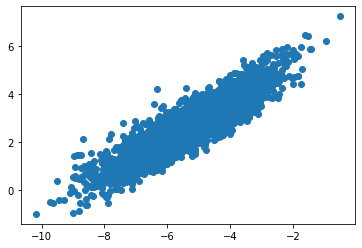

In [285]:
mess_set_FB = mess_set[mess_set['TaggedPitchType'] == 'Fastball']
# Show correlation between pitch height and VAA before normalization
plt.scatter(mess_set_FB['VertApprAngle'], mess_set_FB['PlateLocHeight'])

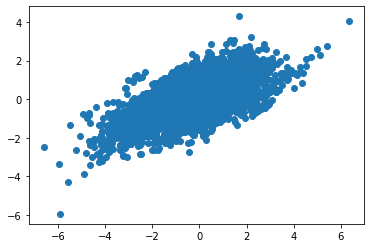

In [286]:
plt.scatter(mess_set_FB['HorzApprAngle'], mess_set_FB['PlateLocSide'])

In [287]:
# Calculate adjusted VAA and adjusted HAA
mess_set_adj = []
for p_type in mess_set['TaggedPitchType'].unique():
    mess_set_pitch = mess_set[mess_set['TaggedPitchType'] == p_type]
    both_hands = []
    # Adjusted HAA - normalize for pitch location and pitcher handedness
    for hand in ['Left', 'Right']:
        mess_set_pitch_hand = mess_set_pitch[mess_set_pitch['PitcherThrows'] == hand]
        mess_set_pitch_hand['side_bin'] = pd.cut(mess_set_pitch_hand['PlateLocSide'], bins=15)

        # Calculate mean HAA for each side bin
        haa_by_side = mess_set_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()

        # Merge this back with the original dataframe
        mess_set_pitch_hand = mess_set_pitch_hand.merge(haa_by_side, on='side_bin', suffixes=('', '_mean'))

        # Calculate HAA Above/Below Average
        mess_set_pitch_hand['AdjustedHAA'] = mess_set_pitch_hand['HorzApprAngle'] - mess_set_pitch_hand['HorzApprAngle_mean']
        
        both_hands.append(mess_set_pitch_hand)
        
    mess_set_pitch = pd.concat(both_hands)
    mess_set_pitch['height_bin'] = pd.cut(mess_set_pitch['PlateLocHeight'], bins=15)

    # Calculate mean VAA for each height bin
    vaa_by_height = mess_set_pitch.groupby('height_bin')['VertApprAngle'].mean().reset_index()

    # Merge this back with the original dataframe
    mess_set_pitch = mess_set_pitch.merge(vaa_by_height, on='height_bin', suffixes=('', '_mean'))

    # Calculate VAA Above/Below Average
    mess_set_pitch['AdjustedVAA'] = mess_set_pitch['VertApprAngle'] - mess_set_pitch['VertApprAngle_mean']
    
    # Will drop PlateLocSide and PlateLocHeight when applied to all_pitches dataframe
    mess_set_new = mess_set_pitch.drop(columns = ['VertApprAngle', 'HorzApprAngle', 'height_bin', 'side_bin', 'VertApprAngle_mean', 'HorzApprAngle_mean'])
    if p_type == 'Fastball':
        mess_set_adj = mess_set_new
    else:
        mess_set_adj = mess_set_adj.append(mess_set_new)

mess_set_adj

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\1511347417.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_set_pitch_hand['side_bin'] = pd.cut(mess_set_pitch_hand['PlateLocSide'], bins=15)
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\1511347417.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_set_pitch_hand['side_bin'] = pd.cut(mess_set_pitch_hand['PlateLocSide'], bins=15)
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\1511347417.py:9: SettingWithC

index        Date             Pitcher PitcherTeam PitcherThrows  \
0      333  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
1      337  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
2      351  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
3      354  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
4      458  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
..     ...         ...                 ...         ...           ...   
297  10935  2024-02-16       Freeman, Kamu     CAM_CAM         Right   
298   3391  2024-02-16       Yeager, Isaac     WAS_HUS         Right   
299   5712  2024-02-16        Ray, William     WAK_DEA         Right   
300   3115  2024-02-16            Hood, CJ     LON_DIR         Right   
301   2587  2024-02-16   Cheeseman, Jeremy     FDU_KNI         Right   

    TaggedPitchType       PitchCall PlayResult  RelSpeed  PlateLocHeight  \
0          Fastball    StrikeCalled  Undefined  89.56139         2.50382   
1          Fastball    StrikeCalled  Undefined  88.73077         2.80538   
2          Fastball        FoulBall  Undefined  89.71028         2.55383   
3          Fastball          InPlay        Out  90.05652         2.61858   
4          Fastball  StrikeSwinging  Undefined  89.69116         2.55130   
..              ...             ...        ...       ...             ...   
297          Sinker      BallCalled  Undefined  85.31311         4.65344   
298          Sinker      BallCalled  Undefined  90.85933         4.59836   
299          Sinker      BallCalled  Undefined  89.52002         4.33128   
300          Sinker      BallCalled  Undefined  91.99615         4.92723   
301          Sinker      BallCalled  Undefined  88.27265         5.06630   

     PlateLocSide  RelHeight  RelSide  Extension  InducedVertBreak  HorzBreak  \
0         0.41609    5.99563 -2.62557    5.92561          15.26347  -14.75560   
1         0.02230    5.77085 -3.17374    6.21944           8.58748  -16.77414   
2         0.39137    5.95561 -2.99964    6.17858          16.01985  -14.87418   
3         0.26261    5.95849 -3.04142    6.10764          15.32946  -11.85524   
4        -0.01259    5.96190 -3.11298    6.06580          21.10340  -11.99764   
..            ...        ...      ...        ...               ...        ...   
297      -0.23534    6.23593  1.30265    6.01529          11.04753   10.81819   
298       1.01781    6.03487  1.67413    6.19560          12.41178   18.87021   
299       1.47991    4.58005  2.69431    6.17204           4.06811   22.31356   
300       2.31247    5.97962  1.96347    5.35964          15.04564   16.87091   
301       1.69015    5.07237  1.74307    5.59027          10.88591   18.38001   

     AdjustedHAA  AdjustedVAA  
0       0.771710    -0.352832  
1       0.767888    -0.454553  
2       1.148881    -0.211942  
3       1.321952    -0.248385  
4       1.088306     0.218124  
..           ...          ...  
297     0.100251    -0.604838  
298     0.777054     0.065420  
299    -0.283225     0.539417  
300    -0.060266    -0.246269  
301     0.334076     0.246268  

[10000 rows x 18 columns]

Now to visualize the results. Both charts below show no correlation between the adjusted VAA and adjusted HAA and the vertical and horizonal location of the pitch, respectively. This metric can now be used as a feature in the Stuff+ model that captures the location-independent affect of approach angles. 

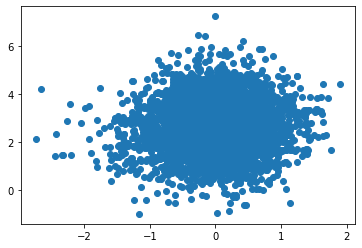

In [288]:
viz_adj = mess_set_adj[mess_set_adj['TaggedPitchType'] == 'Fastball']
plt.scatter(viz_adj['AdjustedVAA'], viz_adj['PlateLocHeight'])

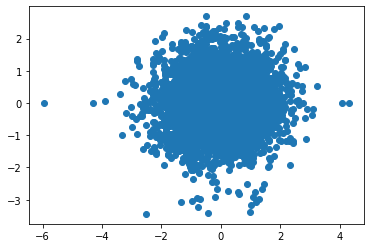

In [289]:
viz_adj = mess_set_adj[mess_set_adj['TaggedPitchType'] == 'Fastball']
plt.scatter(viz_adj['PlateLocSide'], viz_adj['AdjustedHAA'])

Next, I want to look at whether there is any correlation between the new Adjusted VAA and Adjusted HAA metrics and the release point of the pitch.

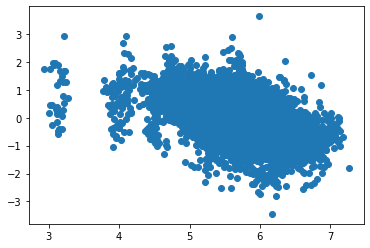

In [290]:
plt.scatter(mess_set_adj['RelHeight'], mess_set_adj['AdjustedVAA'])

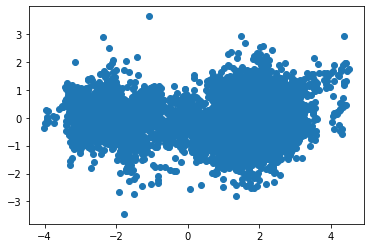

In [291]:
plt.scatter(mess_set_adj['RelSide'], mess_set_adj['AdjustedVAA'])

The first chart, showing the relationship between release height and adjusted VAA shows some negative correlation between the two, but not a lot. All it shows is that once release height exceeds 6ft, it becomes difficult to achieve a flat VAA, but there is enough variation among release heights under 6ft to make it worth keeping it in my model. The second chart, showing the relationship between release side and adjusted HAA shows no correlation between the two. As a result, I will keep both release point metrics in my model as features.

The next step in feature engineering is calculating the difference in movement profiles between each pitcher's primary fastball and their offspeeds. I believe this is a truer reflection of how nasty an offspeed pitch is over its raw movement profile because hitters can and will adjust to the shape of a pitcher's fastball, so differing movement from the fastball will cause whiffs. For instance, two pitchers throw a changeup with 7 IVB and 19 HB, but one has a fastball with 21 IVB and 8 HB while the other has a sinker with 8 IVB and 18 HB, the changeup should not be graded the same. The second pitcher's changeup is nearly identical to his primary fastball, while the first pitcher generates a huge movement difference. Furthermore, the difference in break should help the model more accurately find the characteristics that cause whiffs. I will also account for a difference in velocity when evaluating breaking balls and offspeeds. Some pitchers effectively rely on velocity differences rather than movement differences when throwing these pitches, so I want to capture it in the model.

In [292]:
# Standardize HB to be the same sign for LHP and RHP
mess_set_adj['StandardizedHB'] = mess_set_adj.apply(lambda row: -row['HorzBreak'] if row['PitcherThrows'] == 'Left' else row['HorzBreak'], axis=1)
mess_set_adj

index        Date             Pitcher PitcherTeam PitcherThrows  \
0      333  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
1      337  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
2      351  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
3      354  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
4      458  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
..     ...         ...                 ...         ...           ...   
297  10935  2024-02-16       Freeman, Kamu     CAM_CAM         Right   
298   3391  2024-02-16       Yeager, Isaac     WAS_HUS         Right   
299   5712  2024-02-16        Ray, William     WAK_DEA         Right   
300   3115  2024-02-16            Hood, CJ     LON_DIR         Right   
301   2587  2024-02-16   Cheeseman, Jeremy     FDU_KNI         Right   

    TaggedPitchType       PitchCall PlayResult  RelSpeed  PlateLocHeight  \
0          Fastball    StrikeCalled  Undefined  89.56139         2.50382   
1          Fastball    StrikeCalled  Undefined  88.73077         2.80538   
2          Fastball        FoulBall  Undefined  89.71028         2.55383   
3          Fastball          InPlay        Out  90.05652         2.61858   
4          Fastball  StrikeSwinging  Undefined  89.69116         2.55130   
..              ...             ...        ...       ...             ...   
297          Sinker      BallCalled  Undefined  85.31311         4.65344   
298          Sinker      BallCalled  Undefined  90.85933         4.59836   
299          Sinker      BallCalled  Undefined  89.52002         4.33128   
300          Sinker      BallCalled  Undefined  91.99615         4.92723   
301          Sinker      BallCalled  Undefined  88.27265         5.06630   

     PlateLocSide  RelHeight  RelSide  Extension  InducedVertBreak  HorzBreak  \
0         0.41609    5.99563 -2.62557    5.92561          15.26347  -14.75560   
1         0.02230    5.77085 -3.17374    6.21944           8.58748  -16.77414   
2         0.39137    5.95561 -2.99964    6.17858          16.01985  -14.87418   
3         0.26261    5.95849 -3.04142    6.10764          15.32946  -11.85524   
4        -0.01259    5.96190 -3.11298    6.06580          21.10340  -11.99764   
..            ...        ...      ...        ...               ...        ...   
297      -0.23534    6.23593  1.30265    6.01529          11.04753   10.81819   
298       1.01781    6.03487  1.67413    6.19560          12.41178   18.87021   
299       1.47991    4.58005  2.69431    6.17204           4.06811   22.31356   
300       2.31247    5.97962  1.96347    5.35964          15.04564   16.87091   
301       1.69015    5.07237  1.74307    5.59027          10.88591   18.38001   

     AdjustedHAA  AdjustedVAA  StandardizedHB  
0       0.771710    -0.352832        14.75560  
1       0.767888    -0.454553        16.77414  
2       1.148881    -0.211942        14.87418  
3       1.321952    -0.248385        11.85524  
4       1.088306     0.218124        11.99764  
..           ...          ...             ...  
297     0.100251    -0.604838        10.81819  
298     0.777054     0.065420        18.87021  
299    -0.283225     0.539417        22.31356  
300    -0.060266    -0.246269        16.87091  
301     0.334076     0.246268        18.38001  

[10000 rows x 19 columns]

In [293]:
# Find the fastball each pitcher threw the most frequently (FF, FS, FC)
gb_pitcher = mess_set_adj[(mess_set_adj['TaggedPitchType'] == 'Fastball') | (mess_set_adj['TaggedPitchType'] == 'Sinker') | (mess_set_adj['TaggedPitchType'] == 'Cutter')].groupby(['Pitcher', 'TaggedPitchType']).count()
pitcher_primary_FB = gb_pitcher.groupby(level = 'Pitcher')['Date'].idxmax().apply(lambda x: x[1])
pitcher_primary_FB

Pitcher
Ager, Matt           Fastball
Aiello, Christian    Fastball
Allen, Colby         Fastball
Alloway, Gavin       Fastball
Amborn, Cal          Fastball
                       ...   
Yawn, Garrett        Fastball
Yeager, Isaac          Sinker
Yesavage, Trey       Fastball
Yetter, Brian        Fastball
Young, Brian         Fastball
Name: Date, Length: 247, dtype: object

In [294]:
# Calculate average shape of pitcher's primary fastball
mess_set_adj['primaryFB'] = mess_set_adj['Pitcher'].map(pitcher_primary_FB)
pitcher_FB_shape = mess_set_adj[mess_set_adj['TaggedPitchType'] == mess_set_adj['primaryFB']].groupby('Pitcher')[['RelSpeed','InducedVertBreak', 'StandardizedHB']].mean()
mess_set_adj_shapes = mess_set_adj.merge(pitcher_FB_shape, on='Pitcher', suffixes=('', 'FBavg'))
mess_set_adj_shapes

index        Date               Pitcher PitcherTeam PitcherThrows  \
0       333  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
1       337  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
2       351  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
3       354  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
4       458  2024-02-16    Van Sickle, Bryson     UTA_UTE          Left   
...     ...         ...                   ...         ...           ...   
9995   2533  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   
9996   2529  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   
9997   2530  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   
9998   2532  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   
9999   2537  2024-02-16  Kleinfelter, Matthew     JMU_DUK         Right   

     TaggedPitchType       PitchCall  PlayResult  RelSpeed  PlateLocHeight  \
0           Fastball    StrikeCalled   Undefined  89.56139         2.50382   
1           Fastball    StrikeCalled   Undefined  88.73077         2.80538   
2           Fastball        FoulBall   Undefined  89.71028         2.55383   
3           Fastball          InPlay         Out  90.05652         2.61858   
4           Fastball  StrikeSwinging   Undefined  89.69116         2.55130   
...              ...             ...         ...       ...             ...   
9995          Cutter    StrikeCalled   Undefined  81.73820         1.53740   
9996          Cutter      BallCalled   Undefined  83.00333         3.26504   
9997          Cutter    StrikeCalled   Undefined  84.02201         3.10190   
9998          Cutter      BallCalled   Undefined  81.30962         1.28216   
9999          Cutter      BallCalled  StolenBase  80.65536        -0.61309   

      ...  Extension  InducedVertBreak  HorzBreak  AdjustedHAA  AdjustedVAA  \
0     ...    5.92561          15.26347  -14.75560     0.771710    -0.352832   
1     ...    6.21944           8.58748  -16.77414     0.767888    -0.454553   
2     ...    6.17858          16.01985  -14.87418     1.148881    -0.211942   
3     ...    6.10764          15.32946  -11.85524     1.321952    -0.248385   
4     ...    6.06580          21.10340  -11.99764     1.088306     0.218124   
...   ...        ...               ...        ...          ...          ...   
9995  ...    5.26035           9.36788    0.13472    -2.471004     1.530497   
9996  ...    5.53231           7.17461    0.29909    -2.199729     1.305488   
9997  ...    5.27573           6.59729   -3.14571    -1.725226    -0.256852   
9998  ...    5.40685           6.64804   -0.41508    -1.606043     1.072817   
9999  ...    5.41088           6.17910   -0.61925    -1.731802     1.602581   

      StandardizedHB  primaryFB  RelSpeedFBavg  InducedVertBreakFBavg  \
0           14.75560   Fastball      89.232838              12.707468   
1           16.77414   Fastball      89.232838              12.707468   
2           14.87418   Fastball      89.232838              12.707468   
3           11.85524   Fastball      89.232838              12.707468   
4           11.99764   Fastball      89.232838              12.707468   
...              ...        ...            ...                    ...   
9995         0.13472     Cutter      81.906520               7.508612   
9996         0.29909     Cutter      81.906520               7.508612   
9997        -3.14571     Cutter      81.906520               7.508612   
9998        -0.41508     Cutter      81.906520               7.508612   
9999        -0.61925     Cutter      81.906520               7.508612   

     StandardizedHBFBavg  
0              15.241801  
1              15.241801  
2              15.241801  
3              15.241801  
4              15.241801  
...                  ...  
9995           -0.608899  
9996           -0.608899  
9997           -0.608899  
9998           -0.608899  
9999           -0.608899  

[10000 rows x 23 

In [298]:
# Slice dataframe in two - one for fastballs (all FF, FS, FC will be standalone, not dependent on primary FB shape) - one for 
# offspeed (use avg columns to do array subtraction)
mess_adj_shape_FB = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'Fastball') | (mess_set_adj_shapes['TaggedPitchType'] == 'Sinker') | ((mess_set_adj_shapes['TaggedPitchType'] == 'Cutter') & (mess_set_adj_shapes['primaryFB'] == 'Cutter'))]
mess_adj_shape_BB = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'Curveball') | (mess_set_adj_shapes['TaggedPitchType'] == 'Slider') | ((mess_set_adj_shapes['TaggedPitchType'] == 'Cutter') & (mess_set_adj_shapes['primaryFB'] != 'Cutter'))]
mess_adj_shape_OS = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'ChangeUp') | (mess_set_adj_shapes['TaggedPitchType'] == 'Splitter') | (mess_set_adj_shapes['TaggedPitchType'] == 'Knuckleball')]

mess_adj_shape_BB['VeloDiff'] = mess_adj_shape_BB['RelSpeed'] - mess_adj_shape_BB['RelSpeedFBavg']
mess_adj_shape_BB['IVBDiff'] = mess_adj_shape_BB['InducedVertBreak'] - mess_adj_shape_BB['InducedVertBreakFBavg']
mess_adj_shape_BB['HBDiff'] = mess_adj_shape_BB['StandardizedHB'] - mess_adj_shape_BB['StandardizedHBFBavg']

mess_adj_shape_OS['VeloDiff'] = mess_adj_shape_OS['RelSpeed'] - mess_adj_shape_OS['RelSpeedFBavg']
mess_adj_shape_OS['IVBDiff'] = mess_adj_shape_OS['InducedVertBreak'] - mess_adj_shape_OS['InducedVertBreakFBavg']
mess_adj_shape_OS['HBDiff'] = mess_adj_shape_OS['StandardizedHB'] - mess_adj_shape_OS['StandardizedHBFBavg']

mess_adj_shape_BB

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\2976215820.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_adj_shape_BB['VeloDiff'] = mess_adj_shape_BB['RelSpeed'] - mess_adj_shape_BB['RelSpeedFBavg']
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\2976215820.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_adj_shape_BB['IVBDiff'] = mess_adj_shape_BB['InducedVertBreak'] - mess_adj_shape_BB['InducedVertBreakFBavg']
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipyker

index        Date             Pitcher PitcherTeam PitcherThrows  \
55      405  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
56      334  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
57      342  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
58      440  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
59      336  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
...     ...         ...                 ...         ...           ...   
9967   5707  2024-02-16        Ray, William     WAK_DEA         Right   
9968   5717  2024-02-16        Ray, William     WAK_DEA         Right   
9979  10983  2024-02-16         Troye, Ryan     SAN_GAU         Right   
9980  10980  2024-02-16         Troye, Ryan     SAN_GAU         Right   
9981  10984  2024-02-16         Troye, Ryan     SAN_GAU         Right   

     TaggedPitchType     PitchCall PlayResult  RelSpeed  PlateLocHeight  ...  \
55         Curveball    BallCalled  Undefined  76.20326         0.75848  ...   
56            Slider      FoulBall  Undefined  77.33869         2.49283  ...   
57            Slider      FoulBall  Undefined  75.62675         2.94672  ...   
58            Slider      FoulBall  Undefined  76.64753         2.39937  ...   
59            Slider        InPlay     Single  77.75408         1.91605  ...   
...              ...           ...        ...       ...             ...  ...   
9967          Slider        InPlay        Out  79.58015         1.57233  ...   
9968          Slider        InPlay     Double  80.01195         1.39424  ...   
9979          Slider  StrikeCalled  Undefined  82.66973         2.49908  ...   
9980          Slider    BallCalled  Undefined  81.62017         1.77058  ...   
9981          Slider    BallCalled  Undefined  82.63837         1.57779  ...   

      AdjustedHAA  AdjustedVAA  StandardizedHB  primaryFB  RelSpeedFBavg  \
55       0.212550     0.046978        -4.31610   Fastball      89.232838   
56       0.926026    -1.127232        -7.09296   Fastball      89.232838   
57       1.192919    -0.726199        -8.80158   Fastball      89.232838   
58       0.973813    -1.284005       -11.75705   Fastball      89.232838   
59       0.648719    -1.033744        -7.85355   Fastball      89.232838   
...           ...          ...             ...        ...            ...   
9967    -1.278562     1.112209       -12.34969     Sinker      89.084985   
9968    -1.015990     0.949030       -10.39642     Sinker      89.084985   
9979     0.612564     0.620603        -2.05453     Sinker      89.952319   
9980     1.015865     0.259101        -3.01425     Sinker      89.952319   
9981     0.805000     0.839565        -4.06642     Sinker      89.952319   

      InducedVertBreakFBavg  StandardizedHBFBavg   VeloDiff    IVBDiff  \
55                12.707468            15.241801 -13.029578 -20.264558   
56                12.707468            15.241801 -11.894148 -18.406248   
57                12.707468            15.241801 -13.606088 -15.804518   
58                12.707468            15.241801 -12.585308 -17.381208   
59                12.707468            15.241801 -11.478758 -16.828648   
...                     ...                  ...        ...        ...   
9967               3.073242            20.694207  -9.504835  -6.317652   
9968               3.073242            20.694207  -9.073035  -5.002772   
9979               5.603991            20.149387  -7.282589  -0.901191   
9980               5.603991            20.149387  -8.332149  -5.099541   
9981               5.603991            20.149387  -7.313949  -4.396511   

         HBDiff  
55   -19.557901  
56   -22.334761  
57   -24.043381  
58   -26.998851  
59   -23.095351  
...         ...  
9967 -33.043897  
9968 -31.090627  
9979 -22.203917  
9980 -23.163638  
9981 -24.215808  

[3033 rows x 26 columns]

In [36]:
# apply changes from mess set to full data
def calc_adj_vaa_haa(pitches):
    pitches_adj = []
    for p_type in pitches['TaggedPitchType'].unique():
        pitches_pitch = pitches[pitches['TaggedPitchType'] == p_type]
        both_hands = []
        # Adjusted HAA - normalize for pitch location and pitcher handedness
        for hand in ['Left', 'Right']:
            pitches_pitch_hand = pitches_pitch[pitches_pitch['PitcherThrows'] == hand]
            pitches_pitch_hand['side_bin'] = pd.cut(pitches_pitch_hand['PlateLocSide'], bins=15)

            # Calculate mean HAA for each side bin
            haa_by_side = pitches_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()

            # Merge this back with the original dataframe
            pitches_pitch_hand = pitches_pitch_hand.merge(haa_by_side, on='side_bin', suffixes=('', '_mean'))

            # Calculate HAA Above/Below Average
            pitches_pitch_hand['AdjustedHAA'] = pitches_pitch_hand['HorzApprAngle'] - pitches_pitch_hand['HorzApprAngle_mean']

            both_hands.append(pitches_pitch_hand)

        pitches_pitch = pd.concat(both_hands)
        pitches_pitch['height_bin'] = pd.cut(pitches_pitch['PlateLocHeight'], bins=15)

        # Calculate mean VAA for each height bin
        vaa_by_height = pitches_pitch.groupby('height_bin')['VertApprAngle'].mean().reset_index()

        # Merge this back with the original dataframe
        pitches_pitch = pitches_pitch.merge(vaa_by_height, on='height_bin', suffixes=('', '_mean'))

        # Calculate VAA Above/Below Average
        pitches_pitch['AdjustedVAA'] = pitches_pitch['VertApprAngle'] - pitches_pitch['VertApprAngle_mean']

        # Will drop PlateLocSide and PlateLocHeight when applied to all_pitches dataframe
        pitches_new = pitches_pitch.drop(columns = ['VertApprAngle', 'HorzApprAngle', 'PlateLocHeight', 'PlateLocSide', 'height_bin', 'side_bin', 'VertApprAngle_mean', 'HorzApprAngle_mean'])
        pitches_adj.append(pitches_new)
    return pd.concat(pitches_adj)
    
all_pitches = calc_adj_vaa_haa(all_pitches)

all_pitches['StandardizedHB'] = all_pitches.apply(lambda row: -row['HorzBreak'] if row['PitcherThrows'] == 'Left' else row['HorzBreak'], axis=1)

def get_pitcher_primary_FB_info(pitches):
    gb_pitcher = pitches[(pitches['TaggedPitchType'] == 'Fastball') | (pitches['TaggedPitchType'] == 'Sinker') | (pitches['TaggedPitchType'] == 'Cutter')].groupby(['Pitcher', 'TaggedPitchType']).count()
    pitcher_primary_FB = gb_pitcher.groupby(level = 'Pitcher')['Date'].idxmax().apply(lambda x: x[1])
    pitches['primaryFB'] = pitches['Pitcher'].map(pitcher_primary_FB)
    pitcher_FB_shape = pitches[pitches['TaggedPitchType'] == pitches['primaryFB']].groupby('Pitcher')[['RelSpeed','InducedVertBreak', 'StandardizedHB']].mean()
    pitches_shapes = pitches.merge(pitcher_FB_shape, on='Pitcher', suffixes=('', 'FBavg'))
    return pitches_shapes

all_pitches = get_pitcher_primary_FB_info(all_pitches)

all_pitches_FB = all_pitches[(all_pitches['TaggedPitchType'] == 'Fastball') | (all_pitches['TaggedPitchType'] == 'Sinker') | (all_pitches['TaggedPitchType'] == 'Cutter')]
all_pitches_BB = all_pitches[(all_pitches['TaggedPitchType'] == 'Curveball') | (all_pitches['TaggedPitchType'] == 'Slider')]
all_pitches_OS = all_pitches[(all_pitches['TaggedPitchType'] == 'ChangeUp') | (all_pitches['TaggedPitchType'] == 'Splitter') | (all_pitches['TaggedPitchType'] == 'Knuckleball')]

all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
all_pitches_BB['HBDiff'] = all_pitches_BB['StandardizedHB'] - all_pitches_BB['StandardizedHBFBavg']

all_pitches_OS['VeloDiff'] = all_pitches_OS['RelSpeed'] - all_pitches_OS['RelSpeedFBavg']
all_pitches_OS['IVBDiff'] = all_pitches_OS['InducedVertBreak'] - all_pitches_OS['InducedVertBreakFBavg']
all_pitches_OS['HBDiff'] = all_pitches_OS['StandardizedHB'] - all_pitches_OS['StandardizedHBFBavg']

all_pitches

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\1023863925.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches_pitch_hand['side_bin'] = pd.cut(pitches_pitch_hand['PlateLocSide'], bins=15)
C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\1023863925.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  haa_by_side = pitches_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()
C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\1023863925.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


index        Date             Pitcher PitcherTeam PitcherThrows  \
0            333  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
1            335  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
2            337  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
3            338  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
4            340  2024-02-16  Van Sickle, Bryson     UTA_UTE          Left   
...          ...         ...                 ...         ...           ...   
1436403  1534999  2024-05-14       Schuelke, Cam     MSU_BDG         Right   
1436404  1585901  2024-05-17        Durgin, Nick     STE_HAT         Right   
1436405  1591387  2024-05-17     Lohman, Griffin     PUR_BOI         Right   
1436406  1683549  2024-06-02        Ward, Nathan     GRA_CAN         Right   
1436407  1685329  2024-06-02      Bovair, Connor     NOR_TAR         Right   

        TaggedPitchType             PitchCall      PlayResult  RelSpeed  \
0              Fastball          StrikeCalled       Undefined  89.56139   
1              Fastball              FoulBall       Undefined  91.17097   
2              Fastball          StrikeCalled       Undefined  88.73077   
3              Fastball                InPlay  FieldersChoice  88.38328   
4              Fastball            BallCalled       Undefined  88.69125   
...                 ...                   ...             ...       ...   
1436403     Knuckleball          StrikeCalled       Undefined  68.85133   
1436404     Knuckleball  FoulBallNotFieldable       Undefined  82.93742   
1436405     Knuckleball            BallCalled       Undefined  82.82098   
1436406     Knuckleball            BallCalled       Undefined  77.29063   
1436407     Knuckleball  FoulBallNotFieldable       Undefined  90.83780   

         RelHeight  ...  Extension  InducedVertBreak  HorzBreak  AdjustedHAA  \
0          5.99563  ...    5.92561          15.26347  -14.75560     0.418580   
1          6.12401  ...    5.56583          21.60442  -13.08434     0.275133   
2          5.77085  ...    6.21944           8.58748  -16.77414     1.194025   
3          5.78454  ...    6.13697           7.92347  -16.73552     1.057966   
4          5.76804  ...    6.05549           8.08426  -14.43005     0.946016   
...            ...  ...        ...               ...        ...          ...   
1436403    2.23701  ...    4.46941          11.81505  -18.55446    -2.186277   
1436404    6.31967  ...    5.56973           3.07811   -4.59516     0.330219   
1436405    6.18933  ...    4.53251          -2.48819    2.28252     0.224672   
1436406    5.46396  ...    5.44188          -1.98441   -7.61382     0.041203   
1436407    5.71434  ...    5.35475          17.25938   13.80300     1.525789   

         AdjustedVAA  StandardizedHB  primaryFB RelSpeedFBavg  \
0          -0.482110        14.75560     Sinker     88.436251   
1           0.549336        13.08434     Sinker     88.436251   
2          -0.583831        16.77414     Sinker     88.436251   
3          -0.682644        16.73552     Sinker     88.436251   
4          -0.795581        14.43005     Sinker     88.436251   
...              ...             ...        ...           ...   
1436403     2.238172       -18.55446     Sinker     85.164848   
1436404    -1.699487        -4.59516   Fastball     89.528954   
1436405    -1.484021         2.28252   Fastball     88.761039   
1436406    -0.872908        -7.61382   Fastball     87.948690   
1436407     1.108367        13.80300   Fastball     90.709771   

         InducedVertBreakFBavg  StandardizedHBFBavg  
0                    10.740111            14.436070  
1                    10.740111            14.436070  
2                    10.740111            14.436070  
3                    10.740111            14.436070  
4                    10.740111            14.436070  
...                        ...                  ...  
1436403              -6.931951            15.509286  

The features I will use for my model are: RelSpeed, RelHeight, RelSide, Extension, InducedVertBreak, HorzBreak, AdjustedVAA, AdjustedHAA, VeloDiff, IVBDiff, HBDiff (last 3 won't be included in the Fastball model, obviously)

# Initial Model: Logistic Regression

Logistic Regression is not the best method to use for this project but it is something I want to try and it makes sense given the data I have and the outcome I desire. I am basing this Stuff+ model off expected whiff rate (xWhiff). I chose this because I see Stuff+ as the metric that describes how "nasty" a pitch is, and I believe the biggest indicator of nastiness is how often hitters swing and miss. In this case, I will use all of the swings as my training data and the takes as validation/test sets. Each swing either resulted in contact (foul, in play) or a whiff (swinging strike). Since the response (dependent) variable is a binary outcome, and the result I want is some sort of whiff rate or whiff score (between 0 and 1) that determines how that pitch is to produce a whiff, logistic regression makes perfect sense. While it will not do well capturing the intricacies of the data, it gives me a good baseline and a starting point to learn more about the data before choosing another ML algorithm.

In [38]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings

PitchCall   RelSpeed  RelHeight  RelSide  Extension  \
1              FoulBall   91.17097    6.12401 -2.53239    5.56583   
3                InPlay   88.38328    5.78454 -3.27641    6.13697   
5                InPlay   88.97922    5.90387 -3.17586    6.08399   
6              FoulBall   89.34685    5.77796 -3.16381    6.12316   
8              FoulBall   87.87922    5.82114 -3.29665    6.24615   
...                 ...        ...        ...      ...        ...   
1436170          InPlay  100.78390    5.68787  2.23733    5.14248   
1436177  StrikeSwinging  100.75015    5.57337  2.26321    5.10124   
1436188          InPlay  100.73406    5.41998  2.26517    5.26018   
1436193  StrikeSwinging   99.39796    5.53011  2.19111    5.08184   
1436197          InPlay  100.27414    5.58900  2.20989    4.85881   

         InducedVertBreak  StandardizedHB  AdjustedVAA  AdjustedHAA  
1                21.60442        13.08434     0.549336     0.275133  
3                 7.92347        16.73552    -0.682644     1.057966  
5                10.91256        16.81469    -0.937262     1.244567  
6                10.32619        17.97525    -0.285712     0.586107  
8                11.47209        16.78615    -0.981060     0.769545  
...                   ...             ...          ...          ...  
1436170           9.90926        22.37867     0.251926     0.133491  
1436177           6.23717        18.97135     0.351362    -0.278613  
1436188           3.32358        19.67115     0.325294     0.189117  
1436193           5.13862        18.13422     0.203120    -0.163653  
1436197           9.59375        15.79548     0.742214    -0.136901  

[251655 rows x 9 columns]

In [40]:
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

PitchCall   RelSpeed  RelHeight  RelSide  Extension  \
1                0   91.17097    6.12401 -2.53239    5.56583   
3                0   88.38328    5.78454 -3.27641    6.13697   
5                0   88.97922    5.90387 -3.17586    6.08399   
6                0   89.34685    5.77796 -3.16381    6.12316   
8                0   87.87922    5.82114 -3.29665    6.24615   
...            ...        ...        ...      ...        ...   
1436170          0  100.78390    5.68787  2.23733    5.14248   
1436177          1  100.75015    5.57337  2.26321    5.10124   
1436188          0  100.73406    5.41998  2.26517    5.26018   
1436193          1   99.39796    5.53011  2.19111    5.08184   
1436197          0  100.27414    5.58900  2.20989    4.85881   

         InducedVertBreak  StandardizedHB  AdjustedVAA  AdjustedHAA  
1                21.60442        13.08434     0.549336     0.275133  
3                 7.92347        16.73552    -0.682644     1.057966  
5                10.91256        16.81469    -0.937262     1.244567  
6                10.32619        17.97525    -0.285712     0.586107  
8                11.47209        16.78615    -0.981060     0.769545  
...                   ...             ...          ...          ...  
1436170           9.90926        22.37867     0.251926     0.133491  
1436177           6.23717        18.97135     0.351362    -0.278613  
1436188           3.32358        19.67115     0.325294     0.189117  
1436193           5.13862        18.13422     0.203120    -0.163653  
1436197           9.59375        15.79548     0.742214    -0.136901  

[251655 rows x 9 columns]

In [42]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [44]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_FB = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_FB = log_reg_model_FB.predict_proba(X_train)

In [46]:
x_whiff = [x[1] for x in results_FB]
x_whiff[:10]

[0.2815288784052859,
 0.30784865642560244,
 0.31223134903558786,
 0.30502664873600954,
 0.2682580869255603,
 0.20126334589767947,
 0.29215213893179015,
 0.20662222771528832,
 0.3109292329125647,
 0.255748487845337]

In [48]:
avg_x_whiff_train = np.mean(x_whiff)
avg_x_whiff_train

0.27167388032984463

In [50]:
actual_whiff_pct_train = y_train.mean()
actual_whiff_pct_train

0.27167323799389814

Model must be doing something right. Lets see if it holds up for test data

In [53]:
results_test_FB = log_reg_model_FB.predict_proba(X_test)
x_whiff_test = [x[1] for x in results_test_FB]
avg_x_whiff_test = np.mean(x_whiff_test)
actual_whiff_pct_test = y_test.mean()
avg_x_whiff_test, actual_whiff_pct_test

(0.272015789786483, 0.2711595009139315)

Also very close. The model seems to be accurately capturing the frequency of whiffs on fastballs. Now let's use a more robust accuracy metric to determine the strength of the model. I will use Log Loss, or Cross Entropy loss, as it reliably captures loss when the output is a probability and the labels are binary, while taking into account confidence of prediction.

In [56]:
train_log_loss = metrics.log_loss(y_train, x_whiff)
test_log_loss = metrics.log_loss(y_test, x_whiff_test)
train_log_loss, test_log_loss

(0.5713443387483581, 0.5711643906917714)

Compare to baseline of predicting no whiff (~73% of fastballs were not whiffed at) for every pitch

In [59]:
no_skill_baseline_logloss_FB = metrics.log_loss(y_test, np.zeros(y_test.shape[0]))
no_skill_baseline_logloss_FB

9.773579064107741

So yes, the logistic regression model fares better than the trivial model. Now let's visualize the results

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

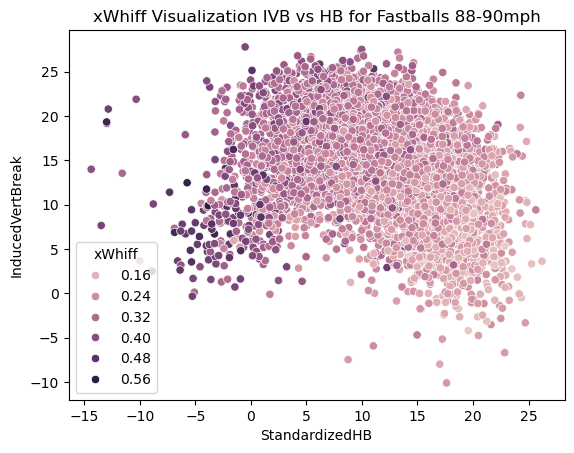

In [62]:
import seaborn as sns

X_test['xWhiff'] = x_whiff_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')]

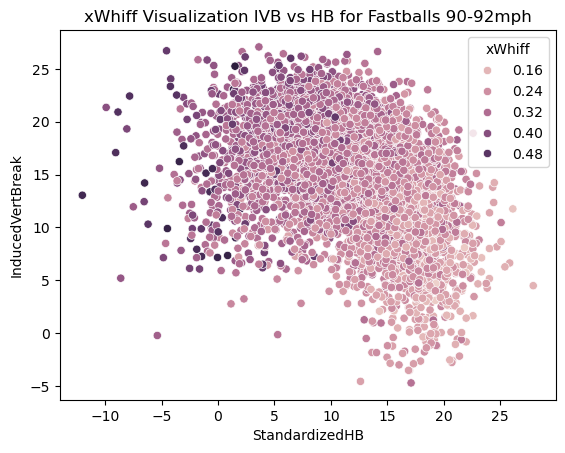

In [64]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

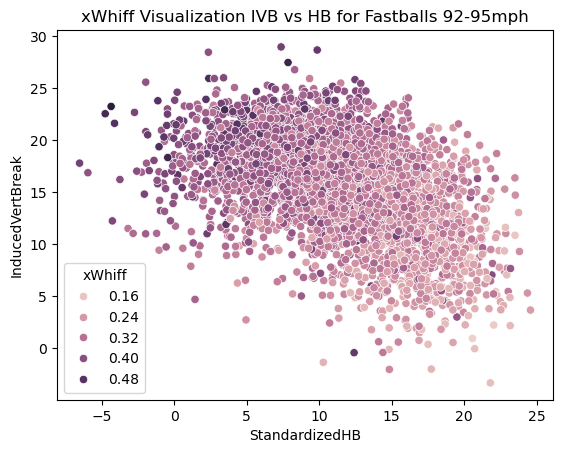

In [66]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs >95mph')]

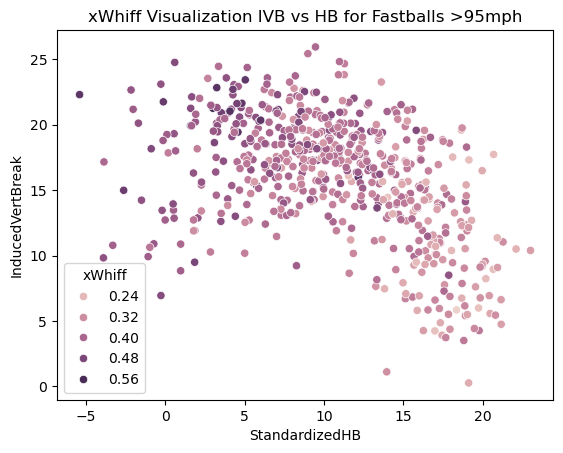

In [67]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 95]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 95]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 95]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs >95mph')

These visualizations don't capture all the features in the model, but they give a good sense of what the model is doing. A few things stand out. First of all, as the velocity increases over the course of the charts, the concentration of darker purple dots, indicating higher xWhiff, increases. This makes sense, as faster fastballs tend to be swung and missed at more and tend to be better pitches. Secondly, the model (as expected) has difficulty capturing finer elements of the data. It favors high IVB fastballs, which also makes sense, but significantly reduces the xWhiff of low very IVB fastballs. Very low IVB fastballs tend to be very good sinkers, which also generate swings and misses. In my first iteration of the model, I used Horizontal Break as a standard feature, which it struggled to capture as a feature. By leaving horizontal break as is, LHP will throw fastballs with negative HB and righties will throw fastballs with positive HB, and naturally so, this does not align with what logistic regression can capture. However, by flipping the sign of LHP HB, the model now seems to favor cutters, with HB close to 0, so perhaps that is the model saying that pitch type is effective.

To generate baselines for the other pitch types, I will create Logistic Regression models for Breaking Balls and Offspeeds just as I did for fastballs

In [72]:
swings = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'FoulBall') | (all_pitches_BB['PitchCall'] == 'InPlay') | (all_pitches_BB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

PitchCall  RelSpeed  RelHeight  RelSide  Extension  InducedVertBreak  \
863607           0  77.01214    6.32641 -1.68659    5.69175         -13.44532   
863608           1  78.34449    6.24592 -1.51912    5.66769         -14.70434   
863614           0  77.27140    6.05294 -1.78047    5.86374         -11.91044   
863618           0  76.62114    6.29624 -1.67715    5.80499         -10.92934   
863622           0  73.13610    6.32797 -1.63201    5.56573         -13.39320   
...            ...       ...        ...      ...        ...               ...   
1287421          1  90.65707    5.39875  2.02947    5.28638           9.35630   
1287423          1  88.93943    5.33288  1.70100    5.31938           9.40268   
1287424          0  77.36517    4.94622  1.82857    4.53763         -15.80698   
1287425          0  75.90259    4.99481  1.57389    4.74929         -14.53080   
1287426          1  78.95801    4.91003  1.38229    4.84387         -12.73579   

         StandardizedHB  AdjustedVAA  AdjustedHAA   VeloDiff    IVBDiff  \
863607         -4.64500    -0.873305    -0.461140 -11.495353 -34.013056   
863608         -8.40398    -0.492023    -0.169904 -10.163003 -35.272076   
863614         -9.11910    -0.380878    -0.148044 -11.236093 -32.478176   
863618         -4.38488    -0.543835    -0.405715 -11.886353 -31.497076   
863622         -9.01823    -1.572114     0.037258 -15.371393 -33.960936   
...                 ...          ...          ...        ...        ...   
1287421         2.89142     2.429936     0.481227  -5.779804   0.789149   
1287423        -1.47630     1.885441     1.017725  -7.497444   0.835529   
1287424       -20.15666    -1.542554    -1.483856 -14.698265 -32.625315   
1287425       -17.04442    -0.970744    -0.638339 -16.160845 -31.349135   
1287426       -17.86462    -0.881003    -0.543906 -13.105425 -29.554125   

            HBDiff  
863607  -18.439866  
863608  -22.198846  
863614  -22.913966  
863618  -18.179746  
863622  -22.813096  
...            ...  
1287421 -14.302503  
1287423 -18.670223  
1287424 -35.954343  
1287425 -32.842103  
1287426 -33.662303  

[125306 rows x 12 columns]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_BB = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_BB = log_reg_model_BB.predict_proba(X_train)
x_whiff_train_BB = [x[1] for x in results_BB]
avg_x_whiff_train_BB = np.mean(x_whiff_train_BB)
actual_whiff_pct_train_BB = y_train.mean()
avg_x_whiff_train_BB, actual_whiff_pct_train_BB

(0.427275318103788, 0.42727554865883394)

In [75]:
results_test_BB = log_reg_model_BB.predict_proba(X_test)
x_whiff_test_BB = [x[1] for x in results_test_BB]
avg_x_whiff_test_BB = np.mean(x_whiff_test_BB)
actual_whiff_pct_test_BB = y_test.mean()
avg_x_whiff_test_BB, actual_whiff_pct_test_BB

(0.42653349153326603, 0.4243875189529966)

In [76]:
train_log_loss_BB = metrics.log_loss(y_train, x_whiff_train_BB)
test_log_loss_BB = metrics.log_loss(y_test, x_whiff_test_BB)
train_log_loss_BB, test_log_loss_BB

(0.6725921788066894, 0.672019935277296)

In [80]:
no_skill_baseline_logloss_BB = metrics.log_loss(y_test, np.zeros(y_test.shape[0]))
no_skill_baseline_logloss_BB

15.296476635809192

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')]

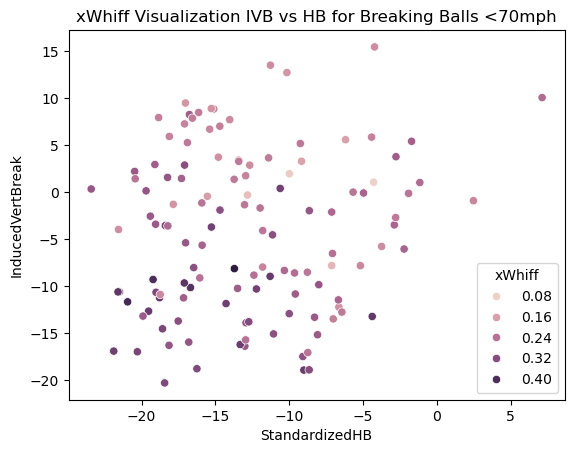

In [82]:
X_test['xWhiff'] = x_whiff_test_BB
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 70)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 70)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 70)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')]

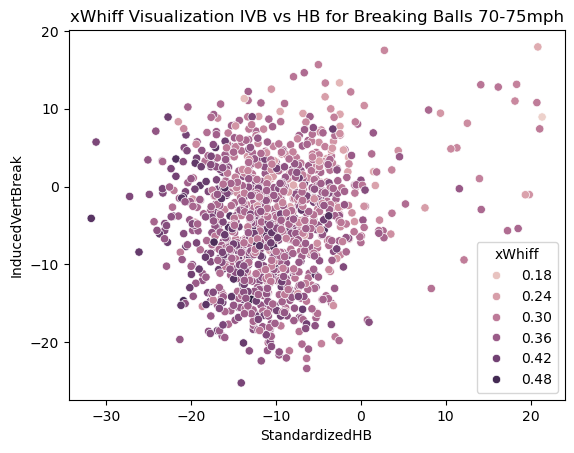

In [84]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')]

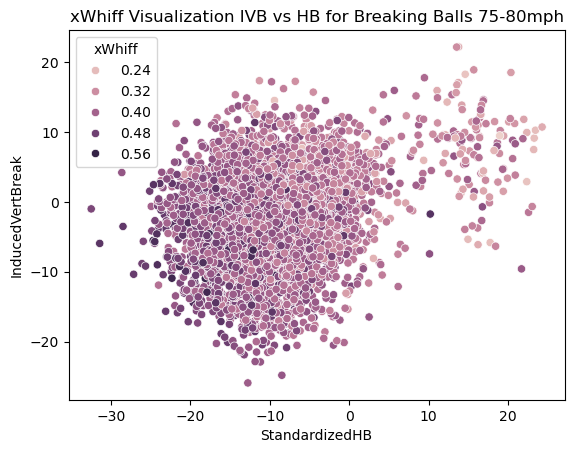

In [86]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')]

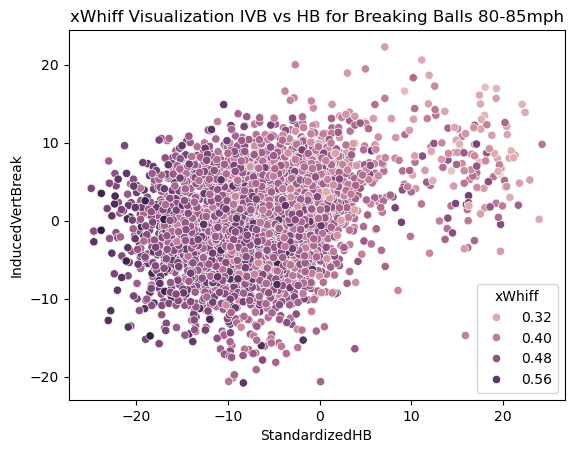

In [87]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')]

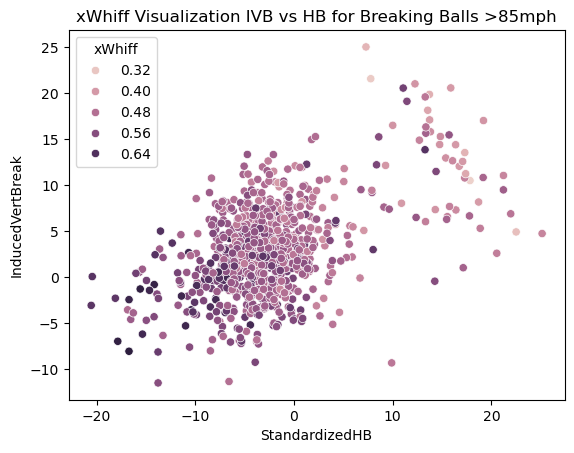

In [88]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 85]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 85]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 85]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')

As with the Fastball model, the Breaking Ball model favors harder breaking balls. The maximum xWhiff on the <70 mph legend is 0.42, right around the average for the dataset, while the maximum xWhiff for the 80-85 and 85+ legends are 0.64. Similarly, the model favors negative IVB and more glove side HB, although it seems more random in the 75-85mph range. Perhaps other features are at play here. All in all, the model favors hard breaking balls with lots of depth, which for a baseball sense, makes a lot of sense, but there is still some intricacy this model has yet to capture.

In [93]:
swings = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'FoulBall') | (all_pitches_OS['PitchCall'] == 'InPlay') | (all_pitches_OS['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

PitchCall  RelSpeed  RelHeight  RelSide  Extension  InducedVertBreak  \
700113           0  83.72878    5.55005 -2.84280    6.31215           6.51591   
700114           1  84.66922    5.54635 -3.19961    6.48382           7.24311   
700115           0  83.12823    5.54974 -3.40462    6.48068           1.00370   
700116           0  84.12075    5.45465 -3.30728    6.50163           9.86603   
700117           0  83.34756    5.50793 -3.18192    6.62342           1.93480   
...            ...       ...        ...      ...        ...               ...   
1436387          0  74.87647    5.42457  2.40042    5.35119          -0.98705   
1436391          1  69.75427    2.29699  2.41276    4.40359          16.82749   
1436393          1  69.78114    2.09715  2.47533    4.21405          19.16871   
1436396          1  68.14309    2.32070  2.47135    4.46655          15.59135   
1436400          1  68.93890    2.30170  2.39766    4.44928          17.22355   

         StandardizedHB  AdjustedVAA  AdjustedHAA   VeloDiff    IVBDiff  \
700113         11.32879     0.380992     1.181691  -4.707471  -4.224201   
700114         15.64387     0.284089     1.375008  -3.767031  -3.497001   
700115         15.44284    -0.455014     1.567167  -5.308021  -9.736411   
700116         14.01052     0.562079     1.458914  -4.315501  -0.874081   
700117         13.53174    -0.171183     1.126681  -5.088691  -8.805311   
...                 ...          ...          ...        ...        ...   
1436387       -10.53367    -1.032465    -1.697908  -9.454856 -13.319708   
1436391       -11.63808     2.990661    -1.039900 -15.410578  23.759441   
1436393       -11.92812     2.818344    -1.366028 -15.383708  26.100661   
1436396       -13.29560     2.179602    -1.388631 -17.021758  22.523301   
1436400       -19.79911     2.009118    -1.586777 -16.225948  24.155501   

            HBDiff  
700113   -3.107280  
700114    1.207800  
700115    1.006770  
700116   -0.425550  
700117   -0.904330  
...            ...  
1436387 -25.984829  
1436391 -27.147366  
1436393 -27.437406  
1436396 -28.804886  
1436400 -35.308396  

[60069 rows x 12 columns]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_OS = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_OS = log_reg_model_OS.predict_proba(X_train)
x_whiff_train_OS = [x[1] for x in results_OS]
avg_x_whiff_train_OS = np.mean(x_whiff_train_OS)
actual_whiff_pct_train_OS = y_train.mean()
avg_x_whiff_train_OS, actual_whiff_pct_train_OS

(0.42386659187930714, 0.42386519181680293)

In [96]:
results_test_OS = log_reg_model_OS.predict_proba(X_test)
x_whiff_test_OS = [x[1] for x in results_test_OS]
avg_x_whiff_test_OS = np.mean(x_whiff_test_OS)
actual_whiff_pct_test_OS = y_test.mean()
avg_x_whiff_test_OS, actual_whiff_pct_test_OS

(0.4235914023187324, 0.4126852005993008)

In [97]:
train_log_loss_OS = metrics.log_loss(y_train, x_whiff_train_OS)
test_log_loss_OS = metrics.log_loss(y_test, x_whiff_test_OS)
train_log_loss_OS, test_log_loss_OS

(0.6687407899888707, 0.666718401167853)

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed <77mph')]

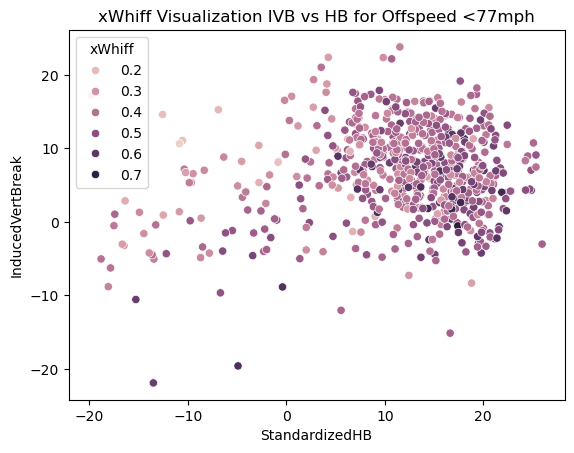

In [98]:
X_test['xWhiff'] = x_whiff_test_OS
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 77)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 77)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 77)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed <77mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 77-80mph')]

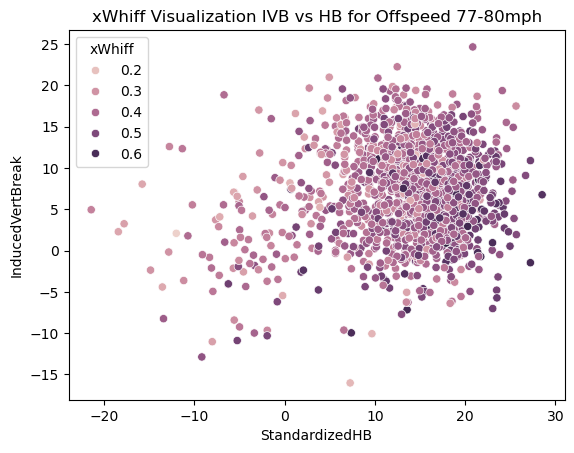

In [102]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 77-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 80-83mph')]

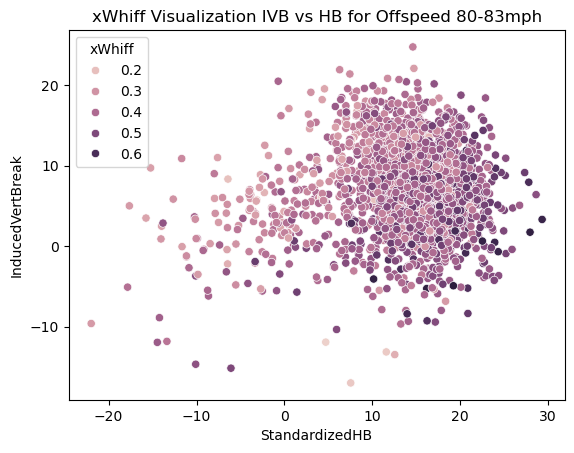

In [103]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 80-83mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 83-86mph')]

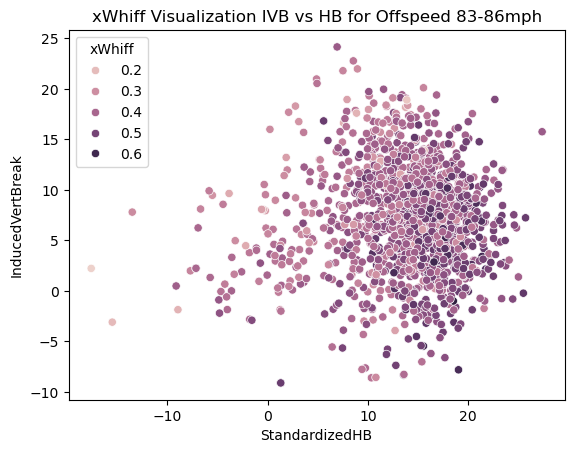

In [104]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 83-86mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed >86mph')]

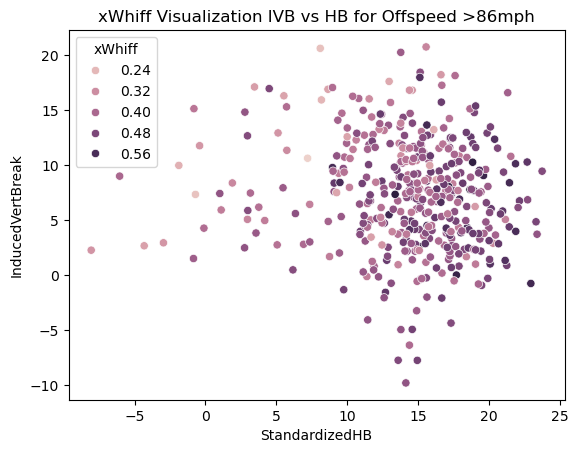

In [107]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 86]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 86]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 86]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed >86mph')

The interpretation of these scatterplots for the Offspeed section is a bit murkier. It does seem to favor arm side HB and slower pitches, which makes semse, but the addition of the VeloDiff, IVBDiff, and HBDiff features I believe has a big effect. From my knowledge of baseball, those really make a difference when it comes to changeups and splitters. As a pitcher, it is much more important to have a changeup that differs from your fastball rather than it being purely a nasty pitch. Let's see if we can visualize the effect of those three features on the model better.

It is also relevant to note that the outlier pitches away from the main cloud are likely mistagged pitches

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')]

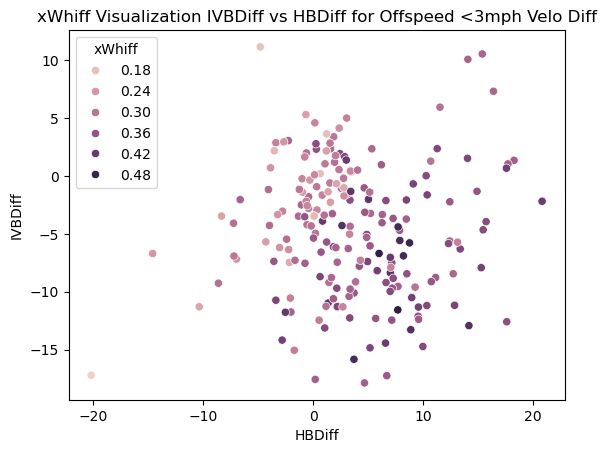

In [112]:
sns.scatterplot(x = X_test[X_test['VeloDiff'] > -3]['HBDiff'], y = X_test[X_test['VeloDiff'] > -3]['IVBDiff'], hue = X_test[X_test['VeloDiff'] > -3]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')]

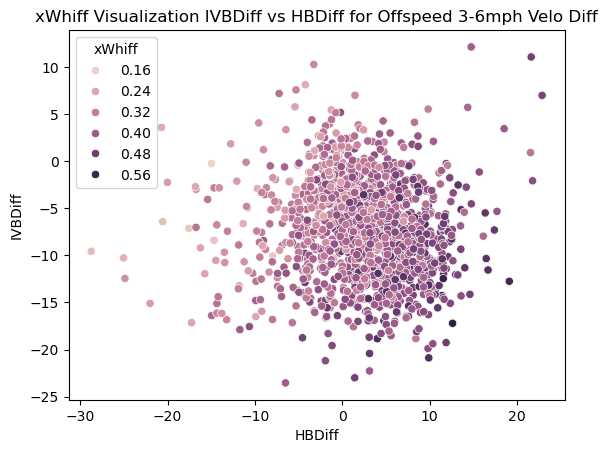

In [114]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')]

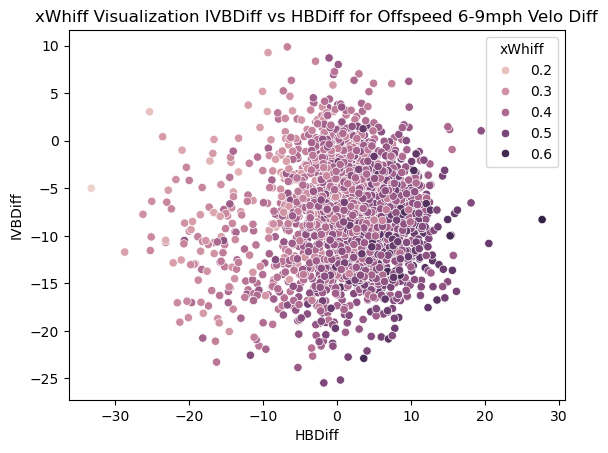

In [115]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')]

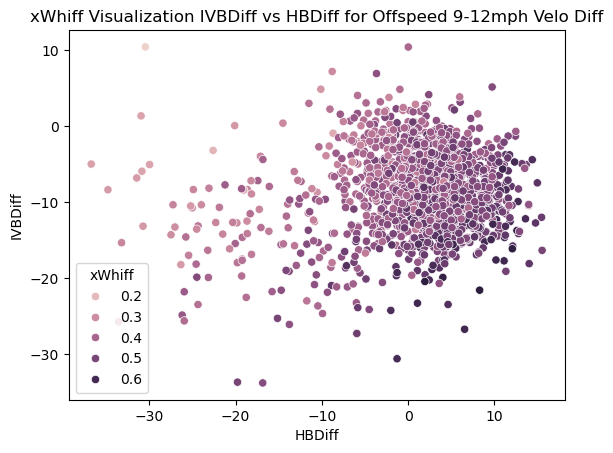

In [117]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')]

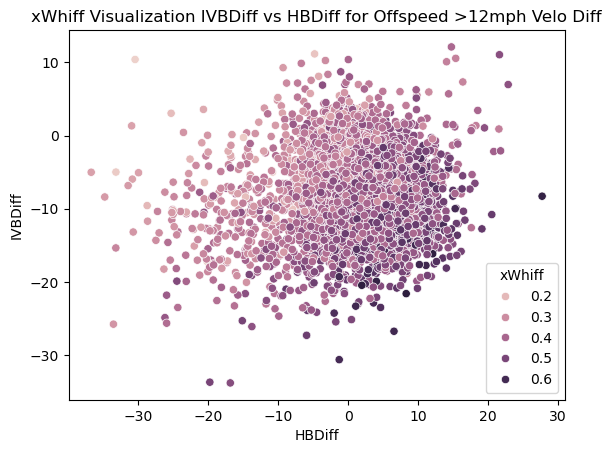

In [119]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')

These plots show a similar trend to the previous ones, but more clearly. The model favors more arm side movement and less velocity for offspeed pitches

# Model 2: Random Forest

In order to capture more intricacies in the model, I will turn to a Random Forest Classifier. Random Forest is a powerful ML algorithm that uses decision trees and boosting to make classifications and return probabilities, exactly what I need for Stuff+. The tree based model will determine the features most important to the prediction and allow for them to be used multiple times in a tree to capture finer details about the features than logistic regression.

For the initial model, I will start with the default number of trees, 100, and choose the max depth to be 8, in order to visualize the effectiveness of the random forest model before tuning these hyperparameters in a later step.

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [125]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

init_model_rand_forest_FB = RandomForestClassifier(n_estimators = 100, max_depth=8, max_features = 'sqrt', random_state=0)
init_model_rand_forest_FB.fit(X_train, y_train)
results_rf_FB = init_model_rand_forest_FB.predict_proba(X_train)
results_rf_FB

array([[0.75236349, 0.24763651],
       [0.69485722, 0.30514278],
       [0.66089518, 0.33910482],
       ...,
       [0.79342913, 0.20657087],
       [0.60456769, 0.39543231],
       [0.80478353, 0.19521647]])

In [126]:
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
avg_x_whiff_rf_FB_train = np.mean(x_whiff_rf_FB_train)
actual_whiff_pct_train_rf_FB = y_train.mean()
avg_x_whiff_rf_FB_train, actual_whiff_pct_train_rf_FB

(0.27161468719339665, 0.27167323799389814)

In [127]:
results_rf_FB_test = init_model_rand_forest_FB.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

train_log_loss_rf_FB = metrics.log_loss(y_train, x_whiff_rf_FB_train)
test_log_loss_rf_FB = metrics.log_loss(y_test, x_whiff_rf_FB_test)
train_log_loss_rf_FB, test_log_loss_rf_FB

(0.5544625887252623, 0.5591960371502083)

The log loss is slightly lower than Logistic Regression, which is a positive step. I will tune the model further, but for now, let's visualize the results with IVB vs HB again.

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

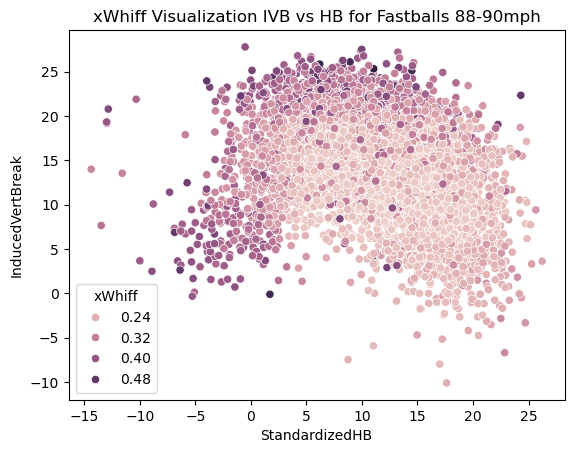

In [131]:
X_test['xWhiff'] = x_whiff_rf_FB_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

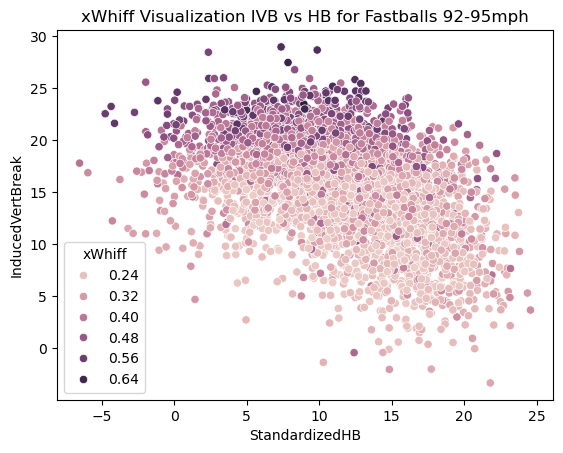

In [133]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

These look really good! Not only is the log loss lower, but the model seems to be making clearer predictions. There is a clear difference in xWhiff for ride fastballs (more IVB) in both plots and Cutters (HB~0) in the 88-90 plot. The logistic regression model was able to find favorable traits, but it was much more random in its predictions than the random forest. Next, I will tune the model to find the optimal number of trees and tree depth based on log loss.

In [135]:
X_test = X_test.drop(columns = ['xWhiff'])

In [210]:
for n in np.arange(25, 126, 25):
    for d in np.arange(2, 16, 1):
        model_rand_forest_FB = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest_FB.fit(X_train, y_train)
        results_rf_FB = model_rand_forest_FB.predict_proba(X_train)
        x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
        results_rf_FB_test = model_rand_forest_FB.predict_proba(X_test)
        x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]
        train_log_loss_rf_FB = metrics.log_loss(y_train, x_whiff_rf_FB_train)
        test_log_loss_rf_FB = metrics.log_loss(y_test, x_whiff_rf_FB_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf_FB) + " Test loss: " + str(test_log_loss_rf_FB))

25 Trees, Depth: 2 - Train loss: 0.5724967264261354 Test loss: 0.5749558636922321
25 Trees, Depth: 3 - Train loss: 0.5689815267793809 Test loss: 0.5719249583152174
25 Trees, Depth: 4 - Train loss: 0.5660784150731125 Test loss: 0.569854461646016
25 Trees, Depth: 5 - Train loss: 0.5631510652747376 Test loss: 0.5676351026167551
25 Trees, Depth: 6 - Train loss: 0.5603764491127855 Test loss: 0.5661960633762655
25 Trees, Depth: 7 - Train loss: 0.557376844728406 Test loss: 0.5648652110698776
25 Trees, Depth: 8 - Train loss: 0.5540675123681468 Test loss: 0.564212094012605
25 Trees, Depth: 9 - Train loss: 0.5492524155392899 Test loss: 0.5635157701025296
25 Trees, Depth: 10 - Train loss: 0.5432522899809005 Test loss: 0.563752172294578
25 Trees, Depth: 11 - Train loss: 0.5354567105347353 Test loss: 0.5629137914579184
25 Trees, Depth: 12 - Train loss: 0.5254987034503874 Test loss: 0.5630304878007136
25 Trees, Depth: 13 - Train loss: 0.512479827557085 Test loss: 0.5622177505413347
25 Trees, Depth: 

KeyboardInterrupt: 

Based on the hyperparameter tuning above, I will make my random forest model with 50 trees and depth 11. The number of trees turned out to not matter much, while the depth of the trees did. Around 9-11 depth was where the Test loss flattened out while the Train loss wasn't too low (a sign of overfitting). Also, since the amount of trees doesn't adjust loss much, I will choose the lower amount to make the model simpler and less computationally expensive.

In [137]:
model_rand_forest_FB_v1 = RandomForestClassifier(n_estimators = 50, max_depth=11, max_features = 'sqrt', random_state=0)
model_rand_forest_FB_v1.fit(X_train, y_train)
results_rf_FB = model_rand_forest_FB_v1.predict_proba(X_train)
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
results_rf_FB_test = model_rand_forest_FB_v1.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

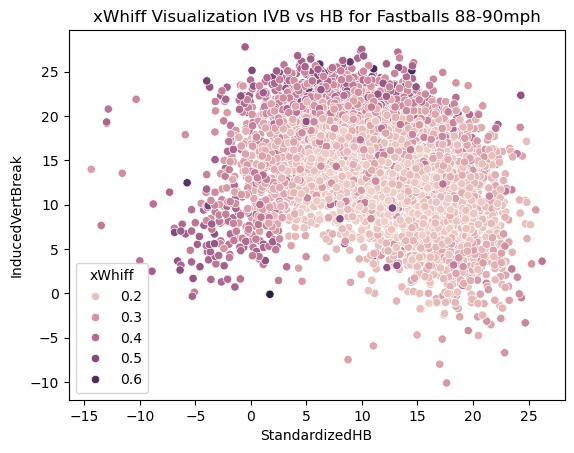

In [138]:
X_test['xWhiff'] = x_whiff_rf_FB_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')]

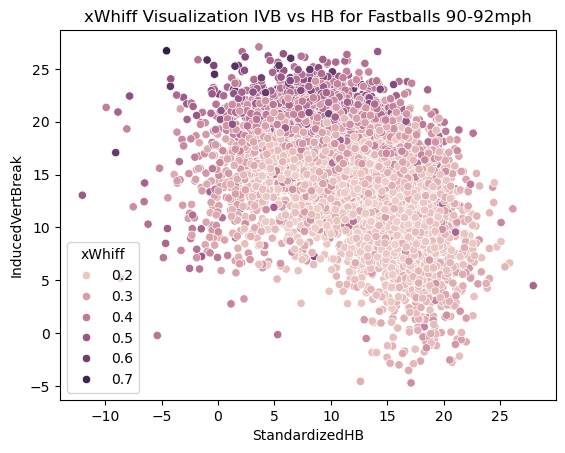

In [139]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

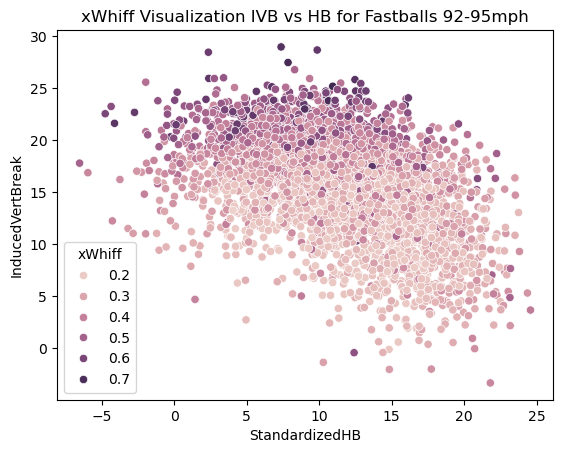

In [140]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs >95mph')]

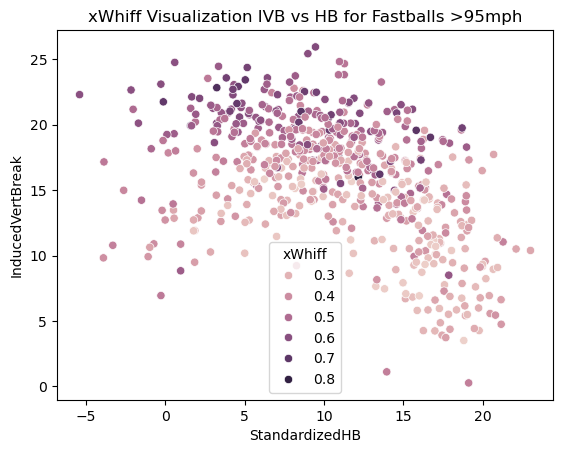

In [141]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 95]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 95]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 95]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs >95mph')

Looks good! Now I will convert xWhiff to Stuff+ and add it to a table containing each pitcher's average for all the features. Stuff+ is simply xWhiff on a scale where 100 is the average and each additional "point" above or below 100 corresponds to 1% above or below the mean. So a Stuff+ of 125 is xWhiff 25% above average, 80 is 20% below average.

In [142]:
takes = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'BallCalled') | (all_pitches_FB['PitchCall'] == 'StrikeCalled')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()

results_rf_fb_takes = model_rand_forest_FB_v1.predict_proba(takes)
x_whiff_rf_fb_takes = [x[1] for x in results_rf_fb_takes]
takes['xWhiff'] = x_whiff_rf_fb_takes
X_train['xWhiff'] = x_whiff_rf_FB_train

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_FB = all_pitches_FB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_FB['Stuff+'] = (all_pitches_FB['xWhiff'] / all_pitches_FB['xWhiff'].mean()) * 100

In [143]:
stuff_plus_leaderboard_FB = all_pitches_FB.groupby(['Pitcher', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_FB['Stuff+'] = stuff_plus_leaderboard_FB['Stuff+'].astype(int)
stuff_plus_leaderboard_FB[:10]

Stuff+   RelSpeed  RelHeight   RelSide  \
Pitcher          TaggedPitchType                                           
Mueller, Matthew Cutter              227  89.545700   6.468305 -0.474215   
Jameson, Fisher  Cutter              222  84.255974   6.961893  0.686051   
Yesavage, Trey   Cutter              218  85.945289   6.843621  1.143196   
Nelson, Cameron  Sinker              214  92.481590   4.459603 -3.361413   
Smith, Hagen     Sinker              213  95.737313   5.489927 -3.360510   
Dean, Tyler      Cutter              213  91.973890   6.132200  1.515820   
Smith, Hagen     Fastball            210  95.592231   5.596785 -3.190081   
Davidson, Zach   Cutter              208  90.952500   6.078520 -0.654650   
Wilson, Nick     Sinker              205  94.018850   5.231120  1.484770   
Chestnutt, Ben   Sinker              204  73.002990   5.128780  2.833510   

                                  Extension  InducedVertBreak  HorzBreak  \
Pitcher          TaggedPitchType                                           
Mueller, Matthew Cutter            6.642875         25.395310 -11.759120   
Jameson, Fisher  Cutter            4.836111          3.930955   1.890623   
Yesavage, Trey   Cutter            5.362769          2.981878   2.813450   
Nelson, Cameron  Sinker            6.276827         11.618547 -17.214210   
Smith, Hagen     Sinker            6.215532         15.501743 -14.929315   
Dean, Tyler      Cutter            6.278610         21.342650  -0.597050   
Smith, Hagen     Fastball          6.115964         16.484086 -13.192950   
Davidson, Zach   Cutter            5.764520         23.058200  -1.368940   
Wilson, Nick     Sinker            6.230170         17.349340   7.080240   
Chestnutt, Ben   Sinker            5.706940         -6.280080 -16.980250   

                                  AdjustedVAA  AdjustedHAA  
Pitcher          TaggedPitchType                            
Mueller, Matthew Cutter              1.231809    -2.892036  
Jameson, Fisher  Cutter             -1.441035     1.510551  
Yesavage, Trey   Cutter             -1.343469     0.984755  
Nelson, Cameron  Sinker              1.531333     1.166450  
Smith, Hagen     Sinker              0.937745     1.304571  
Dean, Tyler      Cutter              1.302040     0.362891  
Smith, Hagen     Fastball            0.702100     1.323944  
Davidson, Zach   Cutter              1.323992    -1.558109  
Wilson, Nick     Sinker              1.569375    -0.421041  
Chestnutt, Ben   Sinker             -2.617521    -3.914274

In [144]:
all_pitches_FB = all_pitches_FB.drop(columns = ['xWhiff', 'Stuff+'])

After I first found the Stuff+ Leaderboard for the random forest model, I noticed that the model very much favors cutters. Most of the top cutters seemed to be closer to sliders or misreads/mistags. Since breaking balls naturally have a higher whiff rate than fastballs (42% to 27%, see logistic regression models), cutters that act more like sliders will naturally produce more whiff characterstics, and cause an unfair comparison when compared to fastballs. However, lots of pitchers throw cutters as their primary fastball that don't act similarly to sliders. So, for my final model, I came up with an idea: I'll move cutters to breaking ball model for pitchers whose primary FB is not a cutter, keep in FB model for those who it is their primary fastball.

I will also remove Knuckleballs from the Offspeed model. I would like to calculate Stuff+ for Knuckleballs as well, but from inspecting the data, it seems as if not all the Knuckleballs are actually knuckleballs. Some were either mistagged or the tag was used as a placeholder for a misread.

In [154]:
all_pitches_FB = all_pitches[(all_pitches['TaggedPitchType'] == 'Fastball') | (all_pitches['TaggedPitchType'] == 'Sinker') | ((all_pitches['TaggedPitchType'] == 'Cutter') & (all_pitches['primaryFB'] == 'Cutter'))]
all_pitches_BB = all_pitches[(all_pitches['TaggedPitchType'] == 'Curveball') | (all_pitches['TaggedPitchType'] == 'Slider') | ((all_pitches['TaggedPitchType'] == 'Cutter') & (all_pitches['primaryFB'] != 'Cutter'))]
all_pitches_OS = all_pitches[(all_pitches['TaggedPitchType'] == 'ChangeUp') | (all_pitches['TaggedPitchType'] == 'Splitter')]

all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
all_pitches_BB['HBDiff'] = all_pitches_BB['StandardizedHB'] - all_pitches_BB['StandardizedHBFBavg']

all_pitches_OS['VeloDiff'] = all_pitches_OS['RelSpeed'] - all_pitches_OS['RelSpeedFBavg']
all_pitches_OS['IVBDiff'] = all_pitches_OS['InducedVertBreak'] - all_pitches_OS['InducedVertBreakFBavg']
all_pitches_OS['HBDiff'] = all_pitches_OS['StandardizedHB'] - all_pitches_OS['StandardizedHBFBavg']

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\1195192432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\1195192432.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\1195192432.py:7: SettingWithCopyWarning: 

# Final Model: Fastballs

In [156]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

model_rand_forest_FB_v2 = RandomForestClassifier(n_estimators = 50, max_depth=11, max_features = 'sqrt', random_state=0)
model_rand_forest_FB_v2.fit(X_train, y_train)
results_rf_FB = model_rand_forest_FB_v2.predict_proba(X_train)
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
results_rf_FB_test = model_rand_forest_FB_v2.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

In [157]:
takes = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'BallCalled') | (all_pitches_FB['PitchCall'] == 'StrikeCalled')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()

results_rf_fb_takes = model_rand_forest_FB_v2.predict_proba(takes)
x_whiff_rf_fb_takes = [x[1] for x in results_rf_fb_takes]
takes['xWhiff'] = x_whiff_rf_fb_takes
X_train['xWhiff'] = x_whiff_rf_FB_train
X_test['xWhiff'] = x_whiff_rf_FB_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_FB = all_pitches_FB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_FB['Stuff+'] = (all_pitches_FB['xWhiff'] / all_pitches_FB['xWhiff'].mean()) * 100

In [173]:
stuff_plus_leaderboard_FB = all_pitches_FB.groupby(['Pitcher', 'PitcherTeam', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_FB['Stuff+'] = stuff_plus_leaderboard_FB['Stuff+'].astype(int)
stuff_plus_leaderboard_FB.to_csv('stuff_plus_fb.csv')
stuff_plus_leaderboard_FB[:10]

Stuff+   RelSpeed  RelHeight  \
Pitcher            PitcherTeam TaggedPitchType                                 
Chestnutt, Ben     MIA_HUR     Sinker              228  73.002990   5.128780   
Smith, Hagen       ARK_RAZ     Fastball            222  95.592231   5.596785   
                               Sinker              220  95.737313   5.489927   
Nelson, Cameron    WAK_DEA     Sinker              218  92.481590   4.459603   
Wilson, Nick       DAL_PAT     Sinker              217  94.018850   5.231120   
Chillot, Gavin     PIT_UNI     Fastball            217  92.437030   5.162390   
Grotyohann, Connor RHO_RAM     Sinker              208  93.194410   6.216450   
Pence, Dalton      NOR_TAR     Fastball            200  92.382857   5.659800   
Mayer, Cameron     UCO_HUS     Cutter              198  85.131260   3.993896   
Conklin, MacCallan ILL_RED     Fastball            196  90.919935   5.404450   

                                                 RelSide  Extension  \
Pitcher            PitcherTeam TaggedPitchType                        
Chestnutt, Ben     MIA_HUR     Sinker           2.833510   5.706940   
Smith, Hagen       ARK_RAZ     Fastball        -3.190081   6.115964   
                               Sinker          -3.360510   6.215532   
Nelson, Cameron    WAK_DEA     Sinker          -3.361413   6.276827   
Wilson, Nick       DAL_PAT     Sinker           1.484770   6.230170   
Chillot, Gavin     PIT_UNI     Fastball         2.101065   5.531395   
Grotyohann, Connor RHO_RAM     Sinker           1.839100   6.309180   
Pence, Dalton      NOR_TAR     Fastball        -1.149213   5.929837   
Mayer, Cameron     UCO_HUS     Cutter           3.704679   6.377367   
Conklin, MacCallan ILL_RED     Fastball         2.437735   6.264600   

                                                InducedVertBreak  HorzBreak  \
Pitcher            PitcherTeam TaggedPitchType                                
Chestnutt, Ben     MIA_HUR     Sinker                  -6.280080 -16.980250   
Smith, Hagen       ARK_RAZ     Fastball                16.484086 -13.192950   
                               Sinker                  15.501743 -14.929315   
Nelson, Cameron    WAK_DEA     Sinker                  11.618547 -17.214210   
Wilson, Nick       DAL_PAT     Sinker                  17.349340   7.080240   
Chillot, Gavin     PIT_UNI     Fastball                22.652375   7.149140   
Grotyohann, Connor RHO_RAM     Sinker                  23.601980   9.118390   
Pence, Dalton      NOR_TAR     Fastball                21.276110  -9.606552   
Mayer, Cameron     UCO_HUS     Cutter                   5.917959   3.441656   
Conklin, MacCallan ILL_RED     Fastball                20.493790   6.144375   

                                                AdjustedVAA  AdjustedHAA  
Pitcher            PitcherTeam TaggedPitchType                            
Chestnutt, Ben     MIA_HUR     Sinker             -2.617521    -3.914274  
Smith, Hagen       ARK_RAZ     Fastball            0.702100     1.323944  
                               Sinker              0.937745     1.304571  
Nelson, Cameron    WAK_DEA     Sinker              1.531333     1.166450  
Wilson, Nick       DAL_PAT     Sinker              1.569375    -0.421041  
Chillot, Gavin     PIT_UNI     Fastball            1.522383    -0.741517  
Grotyohann, Connor RHO_RAM     Sinker              0.835897    -0.770015  
Pence, Dalton      NOR_TAR     Fastball            0.839324    -0.524924  
Mayer, Cameron     UCO_HUS     Cutter              1.775800    -1.711640  
Conklin, MacCallan ILL_RED     Fastball            0.916599    -1.295998

# Final Model: Breaking Balls

In [175]:
swings = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'FoulBall') | (all_pitches_BB['PitchCall'] == 'InPlay') | (all_pitches_BB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

In [240]:
# Tune hyperparameters
for n in np.arange(50, 126, 25):
    for d in np.arange(7, 12, 1):
        model_rand_forest = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest.fit(X_train, y_train)
        results_rf = model_rand_forest.predict_proba(X_train)
        x_whiff_rf_train = [x[1] for x in results_rf]
        results_rf_test = model_rand_forest.predict_proba(X_test)
        x_whiff_rf_test = [x[1] for x in results_rf_test]
        train_log_loss_rf = metrics.log_loss(y_train, x_whiff_rf_train)
        test_log_loss_rf = metrics.log_loss(y_test, x_whiff_rf_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf) + " Test loss: " + str(test_log_loss_rf))

50 Trees, Depth: 7 - Train loss: 0.588058983640183 Test loss: 0.6742062035409051
50 Trees, Depth: 8 - Train loss: 0.5732492535239676 Test loss: 0.6755296213836416
50 Trees, Depth: 9 - Train loss: 0.5533808110521239 Test loss: 0.6794777681262593
50 Trees, Depth: 10 - Train loss: 0.5342116887250904 Test loss: 0.6824573241795953
50 Trees, Depth: 11 - Train loss: 0.5100078377541706 Test loss: 0.6868158709590021
75 Trees, Depth: 7 - Train loss: 0.5852916637395188 Test loss: 0.67427825390816
75 Trees, Depth: 8 - Train loss: 0.5711029911389929 Test loss: 0.6756054112280373
75 Trees, Depth: 9 - Train loss: 0.5520550414071869 Test loss: 0.6794902990610395
75 Trees, Depth: 10 - Train loss: 0.5325602969294896 Test loss: 0.6826685111891296
75 Trees, Depth: 11 - Train loss: 0.5089936624928347 Test loss: 0.6863904791600923
100 Trees, Depth: 7 - Train loss: 0.5844753273099963 Test loss: 0.6740268589119962
100 Trees, Depth: 8 - Train loss: 0.5699512115541627 Test loss: 0.6758030997910043
100 Trees, De

Again, not much difference across the number of trees or depth. 50 trees and with depth 11 it is.

In [179]:
model_rand_forest_BB = RandomForestClassifier(n_estimators = 50, max_depth=11, max_features = 'sqrt', random_state=0)
model_rand_forest_BB.fit(X_train, y_train)
results_rf_BB = model_rand_forest_BB.predict_proba(X_train)
x_whiff_rf_BB_train = [x[1] for x in results_rf_BB]
results_rf_BB_test = model_rand_forest_BB.predict_proba(X_test)
x_whiff_rf_BB_test = [x[1] for x in results_rf_BB_test]

In [180]:
takes = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'BallCalled') | (all_pitches_BB['PitchCall'] == 'StrikeCalled')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()

results_rf_bb_takes = model_rand_forest_BB.predict_proba(takes)
x_whiff_rf_bb_takes = [x[1] for x in results_rf_bb_takes]
takes['xWhiff'] = x_whiff_rf_bb_takes
X_train['xWhiff'] = x_whiff_rf_BB_train
X_test['xWhiff'] = x_whiff_rf_BB_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_BB = all_pitches_BB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_BB['Stuff+'] = (all_pitches_BB['xWhiff'] / all_pitches_BB['xWhiff'].mean()) * 100

In [220]:
stuff_plus_leaderboard_BB = all_pitches_BB.groupby(['Pitcher', 'PitcherTeam', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_BB['Stuff+'] = stuff_plus_leaderboard_BB['Stuff+'].astype(int)
stuff_plus_leaderboard_BB.to_csv('stuff_plus_bb.csv')
stuff_plus_leaderboard_BB[:10]

Stuff+   RelSpeed  RelHeight  \
Pitcher            PitcherTeam TaggedPitchType                                 
Yesavage, Trey     ECU_PIR     Cutter              155  85.945289   6.843621   
Rossi, Tony        CHA_FOR     Curveball           153  84.476002   5.863153   
Thomas, Brett      GIT_YEL     Slider              152  84.927141   6.598149   
Burns, Chase       WAK_DEA     Cutter              152  88.177693   6.516993   
Hults, Connor      FLO_SEM     Slider              151  79.215960   5.790281   
Hess, Ben          ALA_CRI     Curveball           151  76.355854   5.502152   
Mueller, Matthew   GON_BUL     Cutter              151  89.545700   6.468305   
Morton, Isaac      TEX_AGG     Slider              150  85.960820   5.533820   
Wentworth, Jackson KAN_WIL     Curveball           148  83.120107   6.215673   
Meyer, Chase       WES_MOU     Curveball           148  83.902762   5.476078   

                                                 RelSide  Extension  \
Pitcher            PitcherTeam TaggedPitchType                        
Yesavage, Trey     ECU_PIR     Cutter           1.143196   5.362769   
Rossi, Tony        CHA_FOR     Curveball        2.111095   6.092675   
Thomas, Brett      GIT_YEL     Slider           0.680822   4.515271   
Burns, Chase       WAK_DEA     Cutter           2.006302   5.625246   
Hults, Connor      FLO_SEM     Slider          -1.490744   4.649056   
Hess, Ben          ALA_CRI     Curveball        2.266703   5.859645   
Mueller, Matthew   GON_BUL     Cutter          -0.474215   6.642875   
Morton, Isaac      TEX_AGG     Slider           1.383134   5.204412   
Wentworth, Jackson KAN_WIL     Curveball       -0.078959   5.707620   
Meyer, Chase       WES_MOU     Curveball        1.685106   5.533938   

                                                InducedVertBreak  HorzBreak  \
Pitcher            PitcherTeam TaggedPitchType                                
Yesavage, Trey     ECU_PIR     Cutter                   2.981878   2.813450   
Rossi, Tony        CHA_FOR     Curveball               -3.523585 -16.809490   
Thomas, Brett      GIT_YEL     Slider                  -3.137133   5.284208   
Burns, Chase       WAK_DEA     Cutter                  -0.807182  -6.542494   
Hults, Connor      FLO_SEM     Slider                 -17.851495  11.095234   
Hess, Ben          ALA_CRI     Curveball              -16.386430 -16.328110   
Mueller, Matthew   GON_BUL     Cutter                  25.395310 -11.759120   
Morton, Isaac      TEX_AGG     Slider                   2.329967 -16.767812   
Wentworth, Jackson KAN_WIL     Curveball               -7.168831  -2.689419   
Meyer, Chase       WES_MOU     Curveball              -13.163352 -16.282524   

                                                AdjustedVAA  AdjustedHAA  
Pitcher            PitcherTeam TaggedPitchType                            
Yesavage, Trey     ECU_PIR     Cutter             -1.343469     0.984755  
Rossi, Tony        CHA_FOR     Curveball           1.165803    -1.344526  
Thomas, Brett      GIT_YEL     Slider             -0.864806     2.359117  
Burns, Chase       WAK_DEA     Cutter             -1.145208    -0.782721  
Hults, Connor      FLO_SEM     Slider             -1.989470    -0.248534  
Hess, Ben          ALA_CRI     Curveball          -0.485778    -1.489006  
Mueller, Matthew   GON_BUL     Cutter              1.231809    -2.892036  
Morton, Isaac      TEX_AGG     Slider              0.880717    -0.296573  
Wentworth, Jackson KAN_WIL     Curveball           0.361439     2.256552  
Meyer, Chase       WES_MOU     Curveball           0.646957    -0.871194

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')]

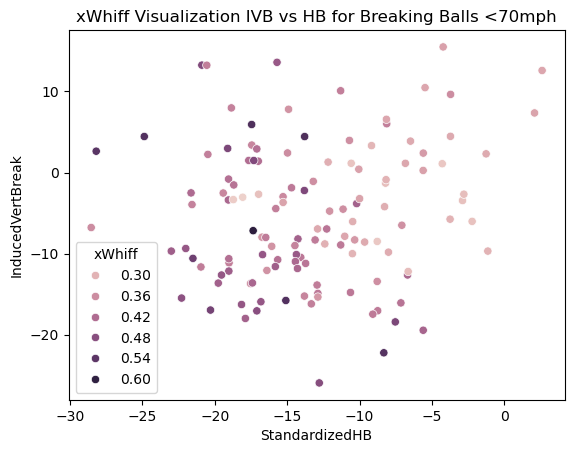

In [182]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 70)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 70)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 70)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')]

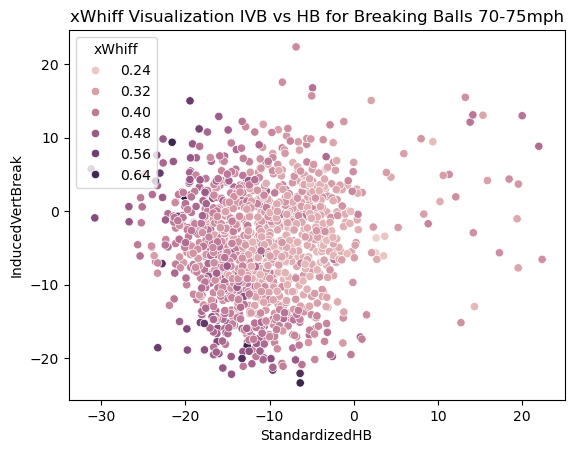

In [183]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')]

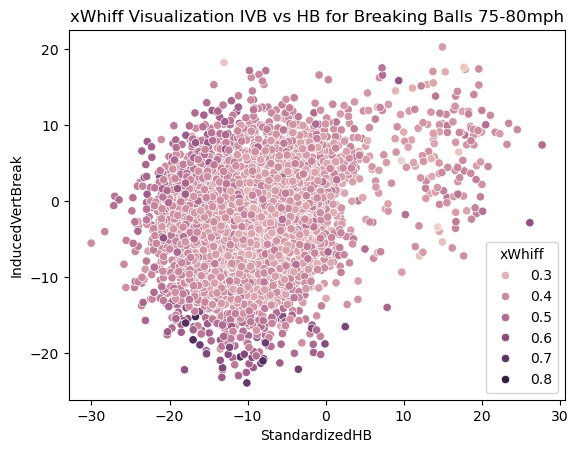

In [184]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')]

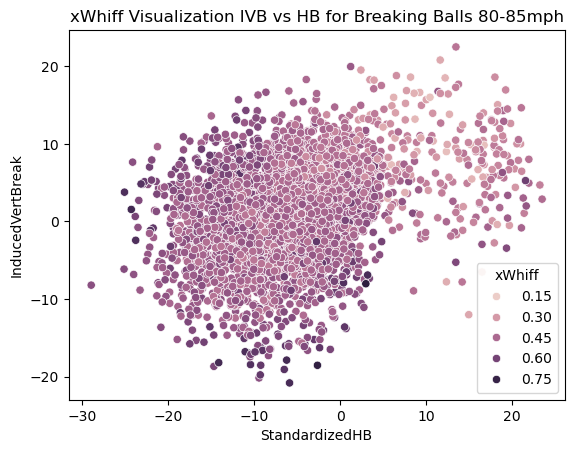

In [185]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')]

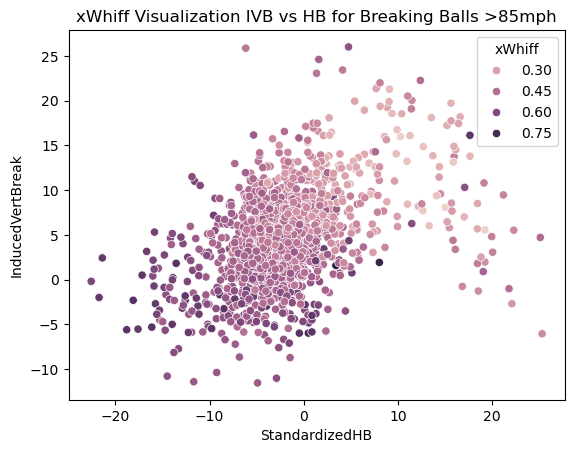

In [186]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 85]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 85]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 85]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')

# Final Model: Offspeeds

In [188]:
swings = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'FoulBall') | (all_pitches_OS['PitchCall'] == 'InPlay') | (all_pitches_OS['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

In [352]:
# Tune Hyperparameters
for n in np.arange(50, 126, 25):
    for d in np.arange(7, 12, 1):
        model_rand_forest = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest.fit(X_train, y_train)
        results_rf = model_rand_forest.predict_proba(X_train)
        x_whiff_rf_train = [x[1] for x in results_rf]
        results_rf_test = model_rand_forest.predict_proba(X_test)
        x_whiff_rf_test = [x[1] for x in results_rf_test]
        train_log_loss_rf = metrics.log_loss(y_train, x_whiff_rf_train)
        test_log_loss_rf = metrics.log_loss(y_test, x_whiff_rf_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf) + " Test loss: " + str(test_log_loss_rf))

50 Trees, Depth: 7 - Train loss: 0.6549510474508438 Test loss: 0.6657624693201604
50 Trees, Depth: 8 - Train loss: 0.6460913404979877 Test loss: 0.6644761276226298
50 Trees, Depth: 9 - Train loss: 0.6350513504628619 Test loss: 0.6637190402326769
50 Trees, Depth: 10 - Train loss: 0.6186925488029941 Test loss: 0.66348227511181
50 Trees, Depth: 11 - Train loss: 0.5996139127498129 Test loss: 0.663448632292774
75 Trees, Depth: 7 - Train loss: 0.6548506762298356 Test loss: 0.6659201682017792
75 Trees, Depth: 8 - Train loss: 0.6460220687953815 Test loss: 0.6641834479150313
75 Trees, Depth: 9 - Train loss: 0.6348972387319577 Test loss: 0.6637408213565364
75 Trees, Depth: 10 - Train loss: 0.619087091622289 Test loss: 0.6633228087438275
75 Trees, Depth: 11 - Train loss: 0.5993605894342786 Test loss: 0.6627715527667136
100 Trees, Depth: 7 - Train loss: 0.6547647051753477 Test loss: 0.6659249689772229
100 Trees, Depth: 8 - Train loss: 0.6458100569290808 Test loss: 0.6644186892237293
100 Trees, Dep

The model seems to overfit to the train data a bit more for the offspeed model than the others with more depth, so I will choose 50 trees with depth 9 for this model.

In [189]:
model_rand_forest_OS = RandomForestClassifier(n_estimators = 50, max_depth=9, max_features = 'sqrt', random_state=0)
model_rand_forest_OS.fit(X_train, y_train)
results_rf_OS = model_rand_forest_OS.predict_proba(X_train)
x_whiff_rf_OS_train = [x[1] for x in results_rf_OS]
results_rf_OS_test = model_rand_forest_OS.predict_proba(X_test)
x_whiff_rf_OS_test = [x[1] for x in results_rf_OS_test]

In [190]:
takes = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'BallCalled') | (all_pitches_OS['PitchCall'] == 'StrikeCalled')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()

results_rf_OS_takes = model_rand_forest_OS.predict_proba(takes)
x_whiff_rf_OS_takes = [x[1] for x in results_rf_OS_takes]
takes['xWhiff'] = x_whiff_rf_OS_takes
X_train['xWhiff'] = x_whiff_rf_OS_train
X_test['xWhiff'] = x_whiff_rf_OS_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_OS = all_pitches_OS.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_OS['Stuff+'] = (all_pitches_OS['xWhiff'] / all_pitches_OS['xWhiff'].mean()) * 100

In [222]:
stuff_plus_leaderboard_OS = all_pitches_OS.groupby(['Pitcher', 'PitcherTeam', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_OS['Stuff+'] = stuff_plus_leaderboard_OS['Stuff+'].astype(int)
stuff_plus_leaderboard_OS.to_csv('stuff_plus_os.csv')
stuff_plus_leaderboard_OS[:10]

Stuff+   RelSpeed  RelHeight  \
Pitcher         PitcherTeam TaggedPitchType                                 
Flynn, Bennett  NOT_IRI     ChangeUp            154  84.642550   6.644560   
Yesavage, Trey  ECU_PIR     ChangeUp            144  84.261768   6.992139   
McNeely, Colby  RID_BRO     ChangeUp            143  83.328120   5.242140   
Causey, AJ      TEN_VOL     ChangeUp            143  79.437251   4.126382   
Yesavage, Trey  ECU_PIR     Splitter            143  82.880559   7.021253   
Weaver, Aidan   DUK_BLU     ChangeUp            142  79.994473   6.359315   
Sweeney, Justin RUT_SCA     ChangeUp            142  82.513230   4.879680   
Leaman, Cole    LEH_MOU     ChangeUp            139  80.595760   5.607690   
Garcia, Brett   ABI_WIL     ChangeUp            137  79.478440   6.124850   
Olson, Luke     OHI_BOB     ChangeUp            137  74.976885   5.140458   

                                              RelSide  Extension  \
Pitcher         PitcherTeam TaggedPitchType                        
Flynn, Bennett  NOT_IRI     ChangeUp         0.420830   5.195890   
Yesavage, Trey  ECU_PIR     ChangeUp         0.981939   5.361589   
McNeely, Colby  RID_BRO     ChangeUp         1.957510   6.361870   
Causey, AJ      TEN_VOL     ChangeUp         1.266410   4.985620   
Yesavage, Trey  ECU_PIR     Splitter         1.010888   5.038918   
Weaver, Aidan   DUK_BLU     ChangeUp         1.292291   6.409824   
Sweeney, Justin RUT_SCA     ChangeUp         1.595330   5.647520   
Leaman, Cole    LEH_MOU     ChangeUp         2.395320   5.866280   
Garcia, Brett   ABI_WIL     ChangeUp         1.175720   5.853650   
Olson, Luke     OHI_BOB     ChangeUp         1.820907   6.822658   

                                             InducedVertBreak  HorzBreak  \
Pitcher         PitcherTeam TaggedPitchType                                
Flynn, Bennett  NOT_IRI     ChangeUp                -9.327450  -3.542480   
Yesavage, Trey  ECU_PIR     ChangeUp                 4.546784   8.325860   
McNeely, Colby  RID_BRO     ChangeUp                -4.940710  12.895870   
Causey, AJ      TEN_VOL     ChangeUp                -3.157570  21.287100   
Yesavage, Trey  ECU_PIR     Splitter                 5.636264  11.436817   
Weaver, Aidan   DUK_BLU     ChangeUp                11.840919  16.068633   
Sweeney, Justin RUT_SCA     ChangeUp                -7.233110  15.700990   
Leaman, Cole    LEH_MOU     ChangeUp               -16.348710 -11.814220   
Garcia, Brett   ABI_WIL     ChangeUp               -19.751110  -8.224810   
Olson, Luke     OHI_BOB     ChangeUp                 8.505447  20.123384   

                                             AdjustedVAA  AdjustedHAA  
Pitcher         PitcherTeam TaggedPitchType                            
Flynn, Bennett  NOT_IRI     ChangeUp           -2.282949    -0.394746  
Yesavage, Trey  ECU_PIR     ChangeUp           -1.354408     0.403941  
McNeely, Colby  RID_BRO     ChangeUp           -1.121696    -0.163468  
Causey, AJ      TEN_VOL     ChangeUp            0.436704     1.273079  
Yesavage, Trey  ECU_PIR     Splitter           -0.902486     0.893485  
Weaver, Aidan   DUK_BLU     ChangeUp           -0.719424     0.646973  
Sweeney, Justin RUT_SCA     ChangeUp           -0.322843     0.765787  
Leaman, Cole    LEH_MOU     ChangeUp           -2.331347    -2.720149  
Garcia, Brett   ABI_WIL     ChangeUp           -2.781271    -0.816326  
Olson, Luke     OHI_BOB     ChangeUp           -0.126721     0.505801

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')]

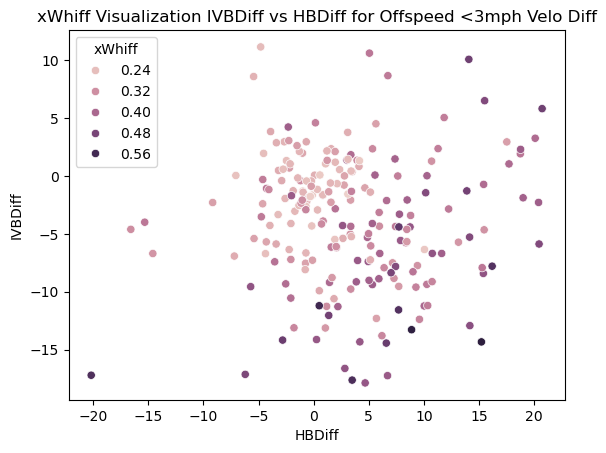

In [192]:
sns.scatterplot(x = X_test[X_test['VeloDiff'] > -3]['HBDiff'], y = X_test[X_test['VeloDiff'] > -3]['IVBDiff'], hue = X_test[X_test['VeloDiff'] > -3]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')]

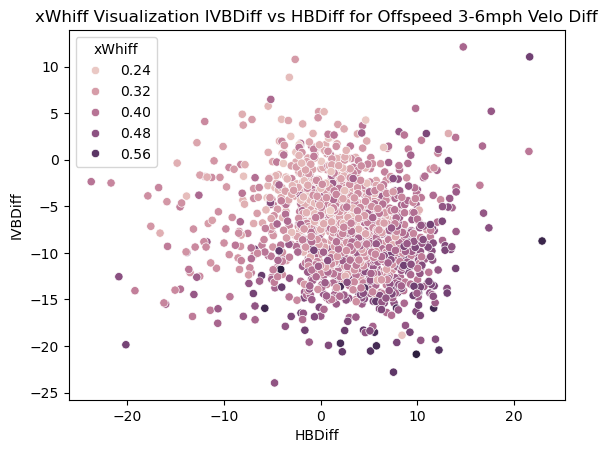

In [193]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')]

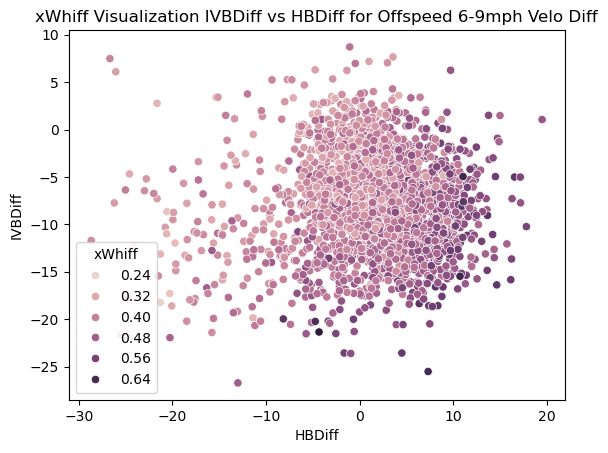

In [194]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')]

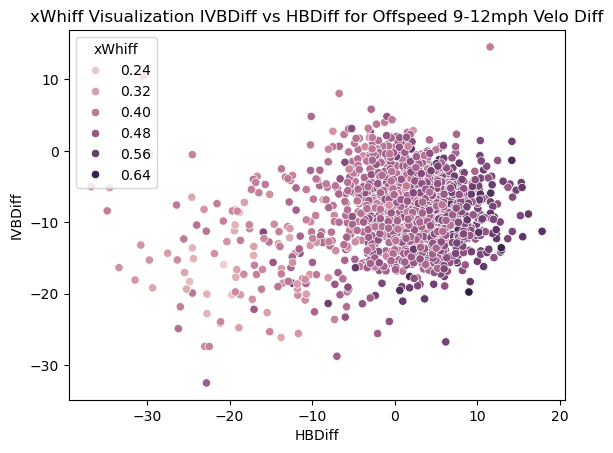

In [195]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')]

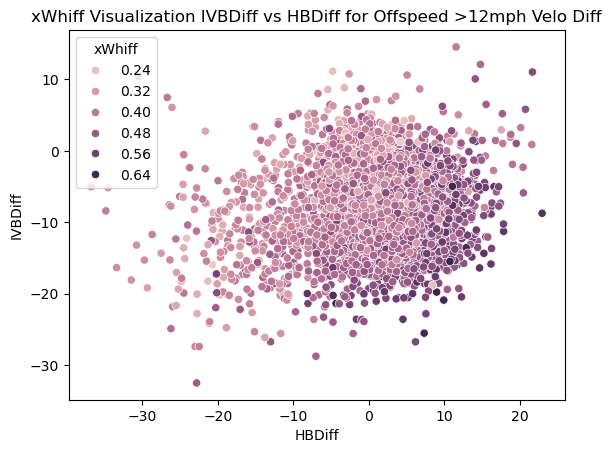

In [196]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')

All my pitches for fun

In [224]:
pd.concat([stuff_plus_leaderboard_FB.loc['Dalquist, Matthew', 'CSD_TRI'], stuff_plus_leaderboard_BB.loc['Dalquist, Matthew', 'CSD_TRI'], stuff_plus_leaderboard_OS.loc['Dalquist, Matthew', 'CSD_TRI']])

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\1629298041.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd.concat([stuff_plus_leaderboard_FB.loc['Dalquist, Matthew', 'CSD_TRI'], stuff_plus_leaderboard_BB.loc['Dalquist, Matthew', 'CSD_TRI'], stuff_plus_leaderboard_OS.loc['Dalquist, Matthew', 'CSD_TRI']])


Stuff+   RelSpeed  RelHeight   RelSide  Extension  \
TaggedPitchType                                                      
Fastball            117  89.514442   5.561379  1.005766   5.734971   
Slider              104  82.391703   5.389155  1.095033   5.430541   
Curveball            85  74.355630   5.510690  0.985665   5.101287   
ChangeUp             98  83.452708   5.223672  1.376832   5.483961   

                 InducedVertBreak  HorzBreak  AdjustedVAA  AdjustedHAA  
TaggedPitchType                                                         
Fastball                20.162068  11.471069     0.608796     0.843036  
Slider                   2.317986  -4.275145     0.673521     1.051524  
Curveball              -10.968255 -12.889769    -0.249460     0.175735  
ChangeUp                 8.851040  17.600799     0.718457     0.804016

All of Trey Yesavage's pitches for fun - he popped up on the top 10 frequently and was picked in the first round by the Blue Jays in 2024

In [226]:
pd.concat([stuff_plus_leaderboard_FB.loc['Yesavage, Trey', 'ECU_PIR'], stuff_plus_leaderboard_BB.loc['Yesavage, Trey', 'ECU_PIR'], stuff_plus_leaderboard_OS.loc['Yesavage, Trey', 'ECU_PIR']])

C:\Users\mdalq\AppData\Local\Temp\ipykernel_23464\1919851967.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  pd.concat([stuff_plus_leaderboard_FB.loc['Yesavage, Trey', 'ECU_PIR'], stuff_plus_leaderboard_BB.loc['Yesavage, Trey', 'ECU_PIR'], stuff_plus_leaderboard_OS.loc['Yesavage, Trey', 'ECU_PIR']])


Stuff+   RelSpeed  RelHeight   RelSide  Extension  \
TaggedPitchType                                                      
Fastball            151  93.998345   6.838701  0.892318   5.473337   
Cutter              155  85.945289   6.843621  1.143196   5.362769   
Slider              138  86.309940   6.807547  1.211594   5.244086   
Curveball           127  81.268487   7.119865  0.928752   5.075362   
ChangeUp            144  84.261768   6.992139  0.981939   5.361589   
Splitter            143  82.880559   7.021253  1.010888   5.038918   

                 InducedVertBreak  HorzBreak  AdjustedVAA  AdjustedHAA  
TaggedPitchType                                                         
Fastball                22.218419   8.865534    -0.277697     0.677278  
Cutter                   2.981878   2.813450    -1.343469     0.984755  
Slider                   3.439346   4.222486    -0.304144     1.709035  
Curveball               -5.267016   1.712416    -0.486734     1.602702  
ChangeUp                 4.546784   8.325860    -1.354408     0.403941  
Splitter                 5.636264  11.436817    -0.902486     0.893485

In [232]:
# export models for use in streamlit app
import joblib

joblib.dump(model_rand_forest_FB_v2, 'FB_model.pkl')
joblib.dump(model_rand_forest_BB, 'BB_model.pkl')
joblib.dump(model_rand_forest_OS, 'OS_model.pkl')

['OS_model.pkl']